# Notebook Contents

- [Imports](#Imports)
- [Data](#Data)
- [Features](#Features)
- [Random Forest](#Random-Forest-Regression-Model)
    - [4-Seam RHP](#4-Seam-RHP)
    - [4-Seam LHP](#4-Seam-LHP)
    - [Cutter RHP](#Cutter-RHP)
    - [Cutter LHP](#Cutter-LHP)
    - [Sinker RHP](#Sinker-RHP)
    - [Sinker LHP](#Sinker-LHP)
    - [Slider RHP](#Slider-RHP)
    - [Slider LHP](#Slider-LHP)
    - [Curveball RHP](#Curveball-RHP)
    - [Curveball LHP](#Curveball-LHP)
    - [Changeup RHP](#Changeup-RHP)
    - [Changeup LHP](#Changeup-LHP)

# Imports

In [1]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn import metrics
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from matplotlib.patches import Rectangle

import warnings
warnings.filterwarnings('ignore')

# Data

In [2]:
data = pd.read_csv('../data/model-pitches-rv.csv', index_col = [0])
data.drop(columns = ['plate_x', 'release_pos_x'], inplace = True)
data.rename(columns = {'pfx_-x': 'pfx_x', 
                       'plate_-x': 'plate_x', 
                       'release_pos_-x': 'release_pos_x'}, 
            inplace = True)

pd.set_option('max_columns', None)
print(data.shape)
data.head()

(705434, 63)


,player_name,p_throws,pitch_type,velo,spin_rate,spin_axis,pfx_x,pfx_z,bauer_units,effective_speed,release_pos_x,release_pos_z,release_extension,release_pos_y,plate_x,plate_z,type,balls,strikes,pitch_count,stand,bb_type,description,events,hit_distance_sc,exit_velo,launch_angle,woba_value,woba_denom,xwoba,at_bat_number,pitch_number,inning,inning_topbot,home_score,away_score,post_home_score,post_away_score,on_1b,on_2b,on_3b,outs_when_up,arm_angle,slot,is_strike,is_ball,final_pitch_ab,out_to_end_inning,home_runs,away_runs,runs,re,re_change,re_end_state,re24,lin_weight_above_avg,lin_weight_above_outs,woba_scale,lin_weights_above_avg_scale,lin_weights_above_outs_scale,woba,wraa_change,rv
0,"Smith, Will",L,FF,92.3,2330.0,148.0,-8.28,16.56,25.243770,92.8,-1.40,6.80,6.5,54.03,0.69,2.83,X,1,2,1-2,R,ground_ball,hit_into_play,field_out,13.0,95.2,-13.0,0.0,1.0,0.158,61,4,9,0,5,0,5,0,0,0,0,2,36.0,1,1,0,1,1,0,0,0,0.11,-0.11,0.00,-0.11,-0.271,0.0,1.209,-0.328,0.0,0.222,-0.152,-0.11
1,"Smith, Will",L,SL,80.6,2254.0,315.0,9.24,5.76,27.965261,81.2,-1.60,6.64,6.4,54.15,0.71,2.62,S,1,1,1-1,R,NaN,strike,NaN,108.0,75.3,75.0,NaN,NaN,NaN,61,3,9,0,5,0,5,0,0,0,0,2,45.8,2,1,0,0,0,0,0,0,0.11,0.00,0.11,0.00,NaN,NaN,1.209,0.000,0.0,0.300,-0.053,0.00
2,"Smith, Will",L,CU,75.5,1940.0,328.0,7.80,-6.12,25.695364,75.2,-1.46,6.88,6.2,54.34,0.04,2.46,S,1,0,1-0,R,NaN,strike,NaN,157.0,83.5,65.0,NaN,NaN,NaN,61,2,9,0,5,0,5,0,0,0,0,2,38.4,1,1,0,0,0,0,0,0,0.11,0.00,0.11,0.00,NaN,NaN,1.209,0.000,0.0,0.356,-0.038,0.00
3,"Smith, Will",L,CU,75.0,2017.0,330.0,8.28,-8.28,26.893333,74.5,-1.53,6.83,5.9,54.61,-2.10,3.89,B,0,0,0-0,R,NaN,ball,NaN,NaN,NaN,NaN,NaN,NaN,NaN,61,1,9,0,5,0,5,0,0,0,0,2,38.4,1,0,1,0,0,0,0,0,0.11,0.00,0.11,0.00,NaN,NaN,1.209,0.000,0.0,0.314,0.028,0.00
4,"Smith, Will",L,FF,91.2,2281.0,143.0,-7.56,15.36,25.010965,90.9,-1.49,6.66,6.3,54.15,0.31,2.80,X,1,0,1-0,L,ground_ball,hit_into_play,field_out,9.0,93.3,-18.0,0.0,1.0,0.090,60,2,9,0,5,0,5,0,0,0,0,1,36.0,1,1,0,1,0,0,0,0,0.29,-0.18,0.11,-0.18,-0.271,0.0,1.209,-0.328,0.0,0.356,-0.038,-0.18


# Cleaning / EDA

### Features

In [3]:
features = data[['player_name', 'p_throws', 'pitch_type', 'velo', 'spin_rate', 
                 'pfx_x', 'pfx_z', 'release_pos_x', 'release_pos_z', 'arm_angle',
                 'release_extension','rv']]

In [4]:
fastball = features[features['pitch_type'].isin(['FF', 'FC', 'SI'])]
breaking_ball = features[features['pitch_type'].isin(['SL', 'CU', 'KC'])]
offspeed = features[features['pitch_type'].isin(['CH', 'FS'])]
rhp = features.loc[features['p_throws'] == 'R']
lhp = features.loc[features['p_throws'] == 'L']
rhp_fastball = fastball.loc[fastball['p_throws'] == 'R']
lhp_fastball = fastball.loc[fastball['p_throws'] == 'L']
rhp_breaking_ball = breaking_ball.loc[breaking_ball['p_throws'] == 'R']
lhp_breaking_ball = breaking_ball.loc[breaking_ball['p_throws'] == 'L']
rhp_offspeed = offspeed.loc[offspeed['p_throws'] == 'R']
lhp_offspeed = offspeed.loc[offspeed['p_throws'] == 'L']
ff_r = rhp.loc[rhp['pitch_type'] == 'FF']
ff_l = lhp.loc[lhp['pitch_type'] == 'FF']
fc_r = rhp.loc[rhp['pitch_type'] == 'FC']
fc_l = lhp.loc[lhp['pitch_type'] == 'FC']
si_r = rhp.loc[rhp['pitch_type'] == 'SI']
si_l = lhp.loc[lhp['pitch_type'] == 'SI']
sl_r = rhp.loc[rhp['pitch_type'] == 'SL']
sl_l = lhp.loc[lhp['pitch_type'] == 'SL']
cu_r = rhp.loc[rhp['pitch_type'] == 'CU']
cu_l = lhp.loc[lhp['pitch_type'] == 'CU']
ch_r = rhp.loc[rhp['pitch_type'] == 'CH']
ch_l = lhp.loc[lhp['pitch_type'] == 'CH']

In [5]:
ff_r.groupby(['player_name', 'pitch_type'], as_index = False)['rv'].sum()

,player_name,pitch_type,rv
0,"Abbott, Cory",FF,7.91
1,"Abreu, Albert",FF,0.24
2,"Abreu, Bryan",FF,2.54
3,"Acevedo, Domingo",FF,3.15
4,"Adam, Jason",FF,4.66
...,...,...,...
588,"Zimmer, Kyle",FF,9.61
589,"Zimmermann, Jordan",FF,-0.24
590,"Zuber, Tyler",FF,7.63
591,"de Geus, Brett",FF,-0.27


# Random Forest Regression Model

# 4-Seam RHP

In [6]:
print('Baseline RHP 4-Seam RunValue Accuracy Score:', round(ff_r.rv.mean(), 2))

Baseline RHP 4-Seam RunValue Accuracy Score: 0.01


In [7]:
features_ff_r = ff_r.select_dtypes([np.number])
X = features_ff_r.drop(columns = ['rv'])
y = features_ff_r['rv']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 1)

rf = RandomForestRegressor(random_state = 1).fit(X_train, y_train)
pred_ff_r = rf.predict(X_test)
pred = rf.predict(X)

print('R2 Test Score:', round((metrics.r2_score(y_test, pred_ff_r)), 3))
print('Test RMSE:', round(np.sqrt(metrics.mean_squared_error(y_test, pred_ff_r)), 3))
print('Test MAE:', round(metrics.mean_absolute_error(y_test, pred_ff_r), 3), '\n')
print('R2 Score:', round((metrics.r2_score(y, pred)), 3))
print('RMSE:', round(np.sqrt(metrics.mean_squared_error(y, pred)), 3))
print('MAE:', round(metrics.mean_absolute_error(y, pred), 3))

R2 Test Score: -0.037
Test RMSE: 0.257
Test MAE: 0.123 

R2 Score: 0.627
RMSE: 0.153
MAE: 0.067


### RHP 4-Seam Actual & Predicted Run Values

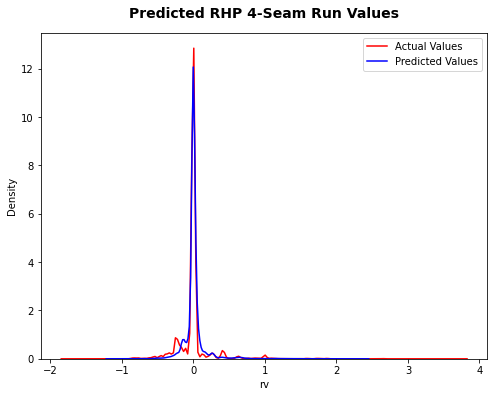

In [8]:
plt.figure(figsize = (8, 6))

ax = sns.distplot(y, hist = False, color = 'r', label = 'Actual Values')
sns.distplot(pred, hist = False, color = 'b', label = 'Predicted Values', ax = ax)
plt.legend()
plt.title('Predicted RHP 4-Seam Run Values', fontsize = 14, fontweight = 'bold', pad = 15);

### RHP 4-Seam RV Table

In [9]:
ff_r['n_pitches'] = [1 if x == 'FF' else 0 for x in ff_r['pitch_type']]
ff_r['xRV'] = pred
grouped_ff_r = ff_r.groupby(['player_name', 'pitch_type'],
                            as_index=False)['n_pitches', 'velo', 'pfx_x', 'pfx_z', 'spin_rate', 'release_pos_x', 
                                            'release_pos_z', 'arm_angle', 'rv', 'xRV'].sum()
grouped_ff_r['RV/100'] = round(((grouped_ff_r['rv'] / grouped_ff_r['n_pitches']) * 100), 2)
grouped_ff_r['xRV/100'] = round(((grouped_ff_r['xRV'] / grouped_ff_r['n_pitches']) * 100), 2)

ff_r_group = pd.merge(ff_r, grouped_ff_r, how = 'left', on = ['player_name'])
drop_cols = ['n_pitches_x', 'pitch_type_y', 'velo_y', 'pfx_x_y', 'pfx_z_y', 'arm_angle_y']
ff_r_group.drop(columns = drop_cols, inplace = True)
col_dict = {
    'pitch_type_x': 'pitch_type', 'n_pitches_y': 'n_pitches', 'velo_x': 'velo',
    'pfx_x_x': 'HB', 'pfx_z_x': 'VB', 'arm_angle_x': 'arm_angle',
    'spin_rate_x': 'spin_rate', 'release_pos_x_x': 'release_pos_x', 
    'release_pos_z_x': 'release_pos_z', 'rv_y': 'RV', 'xRV_y': 'xRV'
}
ff_r_group.rename(columns = col_dict, inplace = True)

ff_r_rv_table = ff_r_group.groupby(['player_name', 'p_throws', 'pitch_type'], 
                                   as_index = False)['n_pitches', 'velo', 'HB', 'VB', 'spin_rate',
                                                     'release_pos_x', 'release_pos_z', 'arm_angle',
                                                     'RV', 'RV/100', 'xRV', 'xRV/100'].mean()
ff_r_rv_table = ff_r_rv_table.round(1)
print(ff_r_rv_table.shape) 
ff_r_rv_table.head()

(593, 15)


,player_name,p_throws,pitch_type,n_pitches,velo,HB,VB,spin_rate,release_pos_x,release_pos_z,arm_angle,RV,RV/100,xRV,xRV/100
0,"Abbott, Cory",R,FF,207.0,92.6,9.6,17.2,2319.9,2.6,5.5,43.3,7.9,3.8,5.1,2.5
1,"Abreu, Albert",R,FF,103.0,97.8,11.7,15.4,2132.3,2.5,5.7,40.8,0.2,0.2,-1.3,-1.2
2,"Abreu, Bryan",R,FF,310.0,95.7,8.0,17.1,2214.8,1.5,6.0,28.7,2.5,0.8,4.0,1.3
3,"Acevedo, Domingo",R,FF,88.0,92.9,12.2,15.1,2065.9,1.6,5.7,31.0,3.2,3.6,1.4,1.6
4,"Adam, Jason",R,FF,125.0,93.8,7.0,16.8,2605.3,1.9,5.7,34.5,4.7,3.7,2.6,2.1


### RHP 4-Seam xRV by HB & VB

RHP 4-Seam Avg xRunValue: 0.01


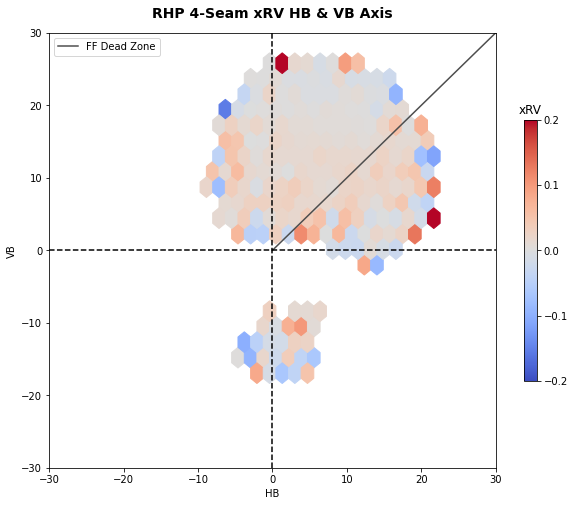

In [10]:
plt.figure(figsize = (10, 8))
plt.hexbin(ff_r['pfx_x'], ff_r['pfx_z'], C = ff_r['xRV'], cmap = 'coolwarm', mincnt = 1, gridsize = 20)
plt.plot([0, 30], [0, 30], ls="-", c=".3", label = 'FF Dead Zone')
cb = plt.colorbar(ticks = [-.2,-.1, 0, .1, .2], shrink = .6)
cb.ax.set_title('xRV'), plt.clim(-.2, .2)
plt.xlabel('HB'), plt.ylabel('VB'), plt.xlim(-30, 30), plt.ylim(-30, 30)
plt.axhline(0, color = 'black', ls = '--'), plt.axvline(0, color = 'black', ls = '--'), plt.legend()
plt.title('RHP 4-Seam xRV HB & VB Axis', fontsize = 14, fontweight = 'bold', pad = 15);
print('RHP 4-Seam Avg xRunValue:', round(ff_r.xRV.mean(), 2))

### RHP 4-Seam xRV by Release Point

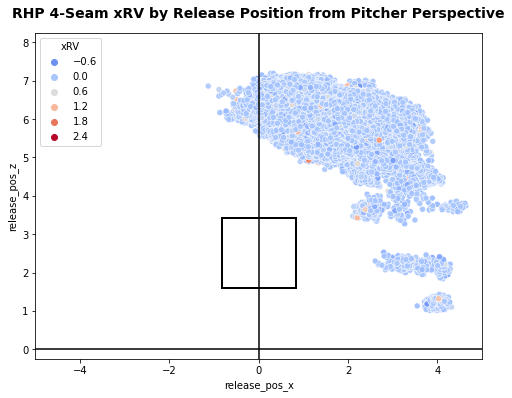

In [11]:
plt.figure(figsize = (8, 6))

sns.scatterplot(data = ff_r, x = 'release_pos_x', y = 'release_pos_z', hue = 'xRV', palette = 'coolwarm')
plt.xlim(-5, 5), plt.ylim(-0.25, 8.25)
plt.axvline(0, color = 'black'), plt.axhline(0, color = 'black')
left, bottom, width, height = (-.83, 1.59, 1.66, 1.82)
plt.gca().add_patch(Rectangle((left, bottom), width, height, fill = False, color = 'black', linewidth = 2))
plt.title('RHP 4-Seam xRV by Release Position from Pitcher Perspective', fontsize = 14, fontweight='bold',pad=15);

### RHP 4-Seam xRV by Release Extension

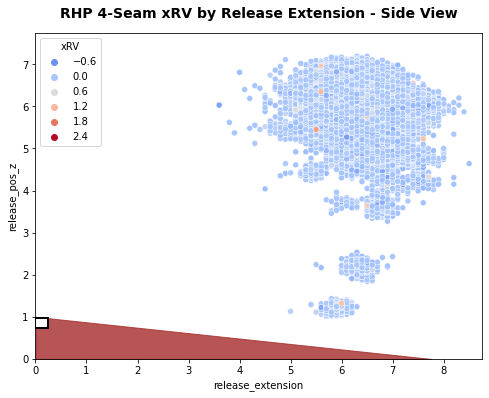

In [12]:
plt.figure(figsize = (8, 6))

sns.scatterplot(data = ff_r, x = 'release_extension', y = 'release_pos_z', hue = 'xRV', palette = 'coolwarm')
plt.xlim(0, 8.75), plt.ylim(0, 7.75)
plt.gca().add_patch(Rectangle((0, .74), .24, .24, fill = True, fc = 'white', ec = 'black', linewidth = 2))
plt.fill_between((7.75, 0), (0, 1), color = 'brown', alpha = .8)
plt.title('RHP 4-Seam xRV by Release Extension - Side View', fontsize = 14, fontweight = 'bold', pad = 15);

### RHP 4-Seam xRV by Velo & Spin Rate

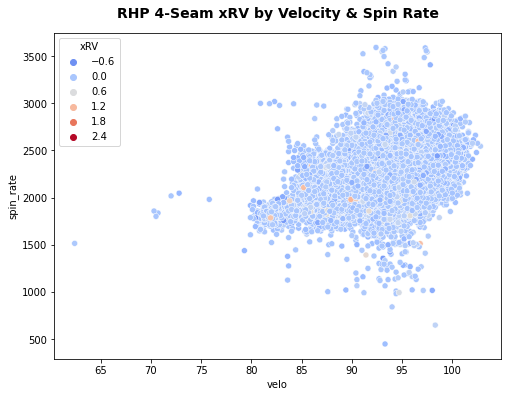

In [13]:
plt.figure(figsize = (8, 6))

sns.scatterplot(data = ff_r, x = 'velo', y = 'spin_rate', hue = 'xRV', palette = 'coolwarm')
plt.title('RHP 4-Seam xRV by Velocity & Spin Rate', fontsize = 14, fontweight = 'bold', pad = 15);

# 4-Seam LHP

In [14]:
print('Baseline LHP 4-Seam RunValue Accuracy Score:', round(ff_l.rv.mean(), 2))

Baseline LHP 4-Seam RunValue Accuracy Score: 0.01


In [15]:
features_ff_l = ff_l.select_dtypes([np.number])
X = features_ff_l.drop(columns = ['rv'])
y = features_ff_l['rv']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 1)

rf = RandomForestRegressor(random_state = 1).fit(X_train, y_train)
pred_ff_l = rf.predict(X_test)
pred = rf.predict(X)

print('R2 Test Score:', round((metrics.r2_score(y_test, pred_ff_l)), 3))
print('Test RMSE:', round(np.sqrt(metrics.mean_squared_error(y_test, pred_ff_l)), 3))
print('Test MAE:', round(metrics.mean_absolute_error(y_test, pred_ff_l), 3), '\n')
print('R2 Score:', round((metrics.r2_score(y, pred)), 3))
print('RMSE:', round(np.sqrt(metrics.mean_squared_error(y, pred)), 3))
print('MAE:', round(metrics.mean_absolute_error(y, pred), 3))

R2 Test Score: -0.053
Test RMSE: 0.254
Test MAE: 0.123 

R2 Score: 0.625
RMSE: 0.152
MAE: 0.067


### LHP 4-Seam Actual & Predicted Run Values

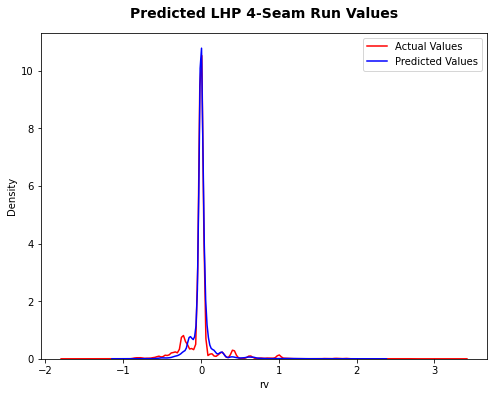

In [16]:
plt.figure(figsize = (8, 6))

ax = sns.distplot(y, hist = False, color = 'r', label = 'Actual Values')
sns.distplot(pred, hist = False, color = 'b', label = 'Predicted Values', ax = ax)
plt.legend()
plt.title('Predicted LHP 4-Seam Run Values', fontsize = 14, fontweight = 'bold', pad = 15);

### LHP 4-Seam RV Table

In [17]:
ff_l['n_pitches'] = [1 if x == 'FF' else 0 for x in ff_l['pitch_type']]
ff_l['xRV'] = pred
grouped_ff_l = ff_l.groupby(['player_name', 'pitch_type'], 
                            as_index = False)['n_pitches', 'velo', 'pfx_x', 'pfx_z', 'spin_rate', 
                                              'release_pos_x', 'release_pos_z', 'arm_angle', 'rv', 'xRV'].sum()
grouped_ff_l['RV/100'] = round(((grouped_ff_l['rv'] / grouped_ff_l['n_pitches']) * 100), 2)
grouped_ff_l['xRV/100'] = round(((grouped_ff_l['xRV'] / grouped_ff_l['n_pitches']) * 100), 2)

ff_l_group = pd.merge(ff_l, grouped_ff_l, how = 'left', on = ['player_name'])
ff_l_group.drop(columns = drop_cols, inplace = True)
ff_l_group.rename(columns = col_dict, inplace = True)
ff_l_rv_table = ff_l_group.groupby(['player_name', 'p_throws', 'pitch_type'], 
                                   as_index = False)['n_pitches', 'velo', 'HB', 'VB', 'spin_rate',
                                                     'release_pos_x', 'release_pos_z', 'arm_angle',
                                                     'RV', 'RV/100', 'xRV', 'xRV/100'].mean()
ff_l_rv_table = ff_l_rv_table.round(1)
print(ff_l_rv_table.shape)
ff_l_rv_table.head()

(210, 15)


,player_name,p_throws,pitch_type,n_pitches,velo,HB,VB,spin_rate,release_pos_x,release_pos_z,arm_angle,RV,RV/100,xRV,xRV/100
0,"Abad, Fernando",L,FF,18.0,91.7,-5.3,16.2,2112.1,-0.5,6.2,11.3,3.0,16.7,2.5,14.1
1,"Aguilar, Miguel",L,FF,62.0,91.4,-4.8,15.7,2163.1,-0.9,5.5,28.6,-0.4,-0.6,1.5,2.4
2,"Akin, Keegan",L,FF,1009.0,92.0,-10.7,18.1,2337.4,-2.4,5.9,77.3,-1.9,-0.2,-3.9,-0.4
3,"Albers, Andrew",L,FF,116.0,88.4,-7.5,18.8,2186.9,-2.0,5.8,63.7,4.0,3.4,3.2,2.8
4,"Alexander, Tyler",L,FF,244.0,90.5,-7.1,16.4,2191.7,-2.1,5.8,67.5,-3.7,-1.5,0.6,0.3


### LHP 4-Seam xRV by HB & VB

LHP 4-Seam Avg xRunValue: 0.01


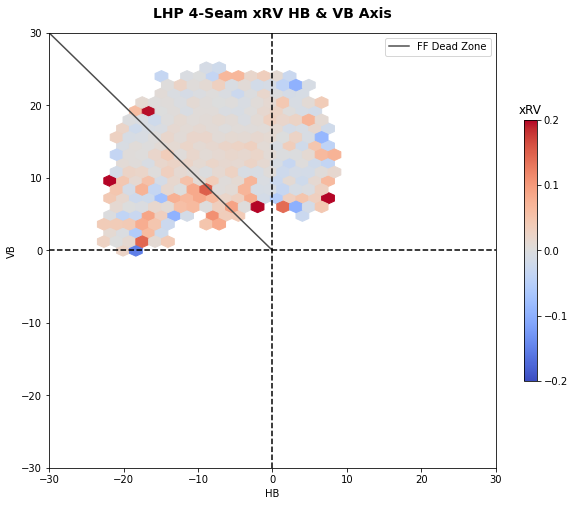

In [18]:
plt.figure(figsize = (10, 8))
plt.hexbin(ff_l['pfx_x'], ff_l['pfx_z'], C = ff_l['xRV'], cmap = 'coolwarm', mincnt = 1, gridsize = 20)
plt.plot([0, -30], [0, 30], ls="-", c=".3", label = 'FF Dead Zone')
cb = plt.colorbar(ticks = [-.2,-.1, 0, .1, .2], shrink = .6)
cb.ax.set_title('xRV'), plt.clim(-.2, .2)
plt.xlabel('HB'), plt.ylabel('VB'), plt.xlim(-30, 30), plt.ylim(-30, 30)
plt.axhline(0, color = 'black', ls = '--'), plt.axvline(0, color = 'black', ls = '--'), plt.legend()
plt.title('LHP 4-Seam xRV HB & VB Axis', fontsize = 14, fontweight = 'bold', pad = 15);
print('LHP 4-Seam Avg xRunValue:', round(ff_l.xRV.mean(), 2))

### LHP 4-Seam xRV by Release Extension

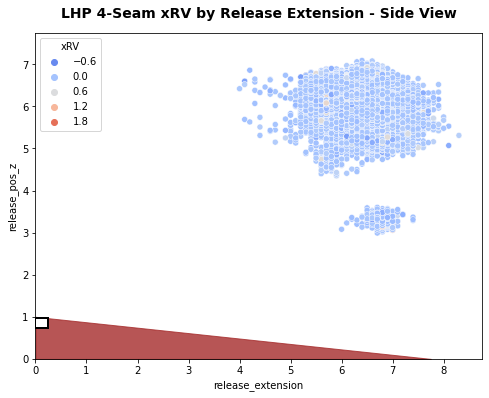

In [19]:
plt.figure(figsize = (8, 6))

sns.scatterplot(data = ff_l, x = 'release_extension', y = 'release_pos_z', hue = 'xRV', palette = 'coolwarm')
plt.xlim(0, 8.75), plt.ylim(0, 7.75)
plt.gca().add_patch(Rectangle((0, .74), .24, .24, fill = True, fc = 'white', ec = 'black', linewidth = 2))
plt.fill_between((7.75, 0), (0, 1), color = 'brown', alpha = .8)
plt.title('LHP 4-Seam xRV by Release Extension - Side View', fontsize = 14, fontweight = 'bold', pad = 15);

### LHP 4-Seam xRV by Release Point

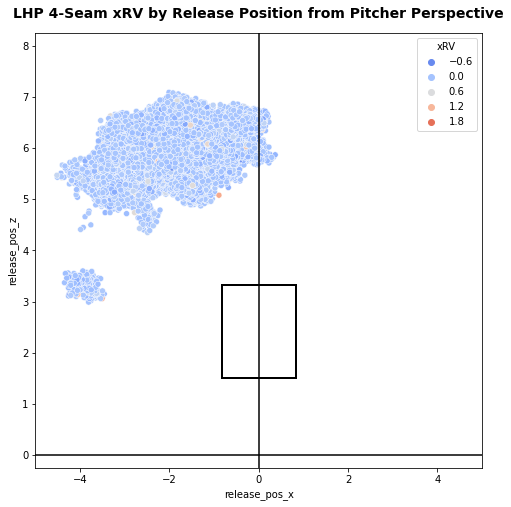

In [20]:
plt.figure(figsize = (8, 8))

sns.scatterplot(data = ff_l, x = 'release_pos_x', y = 'release_pos_z', hue = 'xRV', palette = 'coolwarm')
plt.xlim(-5, 5), plt.ylim(-0.25, 8.25)
plt.axvline(0, color = 'black'), plt.axhline(0, color = 'black')
plt.gca().add_patch(Rectangle((-.83, 1.5), 1.66, 1.82, fill = False, color = 'black', linewidth = 2))
plt.title('LHP 4-Seam xRV by Release Position from Pitcher Perspective', fontsize = 14, fontweight = 'bold', 
           pad = 15);

### LHP 4-Seam xRV by Velo & Spin Rate

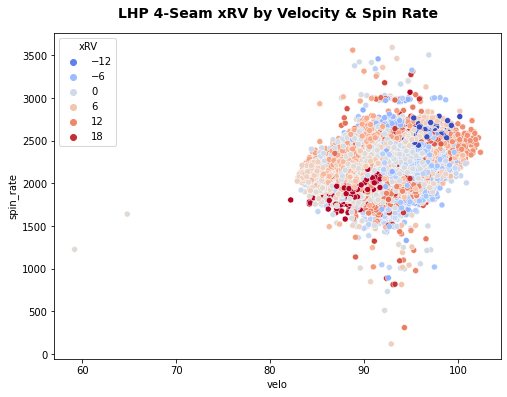

In [21]:
plt.figure(figsize = (8, 6))

sns.scatterplot(data = ff_l_group, x = 'velo', y = 'spin_rate', hue = 'xRV', palette = 'coolwarm')
plt.title('LHP 4-Seam xRV by Velocity & Spin Rate', fontsize = 14, fontweight = 'bold', pad = 15);

# Cutter RHP

In [22]:
print('Baseline RHP Cutter RunValue Accuracy Score:', round(fc_r.rv.mean(), 2))

Baseline RHP Cutter RunValue Accuracy Score: 0.0


In [23]:
features_fc_r = fc_r.select_dtypes([np.number])
X = features_fc_r.drop(columns = ['rv'])
y = features_fc_r['rv']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 1)

rf = RandomForestRegressor(random_state = 1).fit(X_train, y_train)
pred_fc_r = rf.predict(X_test)
pred = rf.predict(X)

print('R2 Test Score:', round((metrics.r2_score(y_test, pred_fc_r)), 3))
print('Test RMSE:', round(np.sqrt(metrics.mean_squared_error(y_test, pred_fc_r)), 3))
print('Test MAE:', round(metrics.mean_absolute_error(y_test, pred_fc_r), 3), '\n')
print('R2 Score:', round((metrics.r2_score(y, pred)), 3))
print('RMSE:', round(np.sqrt(metrics.mean_squared_error(y, pred)), 3))
print('MAE:', round(metrics.mean_absolute_error(y, pred), 3))

R2 Test Score: -0.059
Test RMSE: 0.261
Test MAE: 0.131 

R2 Score: 0.634
RMSE: 0.157
MAE: 0.07


### RHP Cutter Actual & Predicted Values

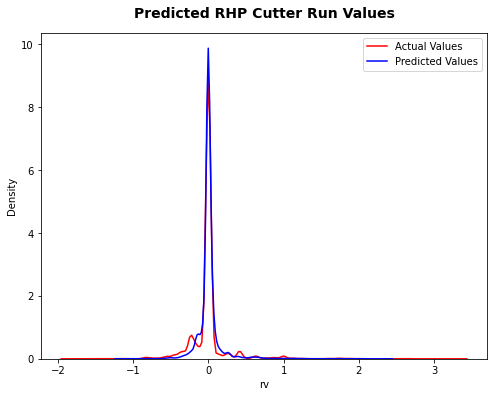

In [24]:
plt.figure(figsize = (8, 6))

ax = sns.distplot(y, hist = False, color = 'r', label = 'Actual Values')
sns.distplot(pred, hist = False, color = 'b', label = 'Predicted Values', ax = ax)
plt.legend()
plt.title('Predicted RHP Cutter Run Values', fontsize = 14, fontweight = 'bold', pad = 15);

### RHP Cutter RV Table

In [25]:
fc_r['n_pitches'] = [1 if x == 'FC' else 0 for x in fc_r['pitch_type']]
fc_r['xRV'] = pred
grouped_fc_r = fc_r.groupby(['player_name', 'pitch_type'], 
                            as_index = False)['n_pitches', 'velo', 'pfx_x', 'pfx_z', 'spin_rate', 
                                              'release_pos_x', 'release_pos_z', 'arm_angle', 'rv', 'xRV'].sum()
grouped_fc_r['RV/100'] = round(((grouped_fc_r['rv'] / grouped_fc_r['n_pitches']) * 100), 2)
grouped_fc_r['xRV/100'] = round(((grouped_fc_r['xRV'] / grouped_fc_r['n_pitches']) * 100), 2)

fc_r_group = pd.merge(fc_r, grouped_fc_r, how = 'left', on = ['player_name'])
fc_r_group.drop(columns = drop_cols, inplace = True)
fc_r_group.rename(columns = col_dict, inplace = True)
fc_r_rv_table = fc_r_group.groupby(['player_name', 'p_throws', 'pitch_type'], 
                                   as_index = False)['n_pitches', 'velo', 'HB', 'VB', 'spin_rate',
                                                     'release_pos_x', 'release_pos_z', 'arm_angle',
                                                     'RV', 'RV/100', 'xRV', 'xRV/100'].mean()
fc_r_rv_table = fc_r_rv_table.round(1)
print(fc_r_rv_table.shape)
fc_r_rv_table.head()

(165, 15)


,player_name,p_throws,pitch_type,n_pitches,velo,HB,VB,spin_rate,release_pos_x,release_pos_z,arm_angle,RV,RV/100,xRV,xRV/100
0,"Alcántara, Sergio",R,FC,1.0,85.9,7.2,15.5,2229.0,2.0,6.0,34.9,0.0,0.0,0.0,2.8
1,"Alzolay, Adbert",R,FC,129.0,90.2,-3.5,6.9,2366.7,1.9,6.1,32.7,2.3,1.8,2.6,2.0
2,"Anderson, Chase",R,FC,191.0,86.6,-3.9,8.1,2293.9,0.9,6.1,17.7,2.3,1.2,6.3,3.3
3,"Anderson, Tanner",R,FC,7.0,87.8,0.5,7.6,2277.0,2.4,5.6,40.0,0.0,0.3,0.1,1.4
4,"Andriese, Matt",R,FC,44.0,85.8,-2.5,3.0,2437.7,2.3,5.8,38.8,2.8,6.4,3.1,7.0


### RHP Cutter xRV by HB & VB

RHP Cutter Avg xRunValue: 0.01


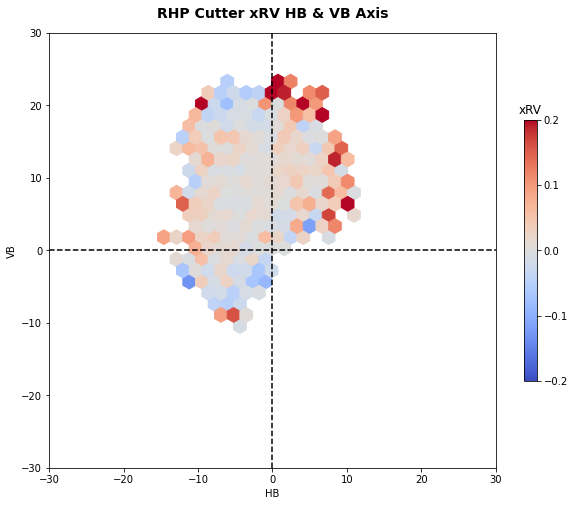

In [26]:
plt.figure(figsize = (10, 8))

plt.hexbin(fc_r['pfx_x'], fc_r['pfx_z'], C = fc_r['xRV'], cmap = 'coolwarm', mincnt = 1, gridsize = 20)
cb = plt.colorbar(ticks = [-.2,-.1, 0, .1, .2], shrink = .6)
cb.ax.set_title('xRV'), plt.clim(-.2, .2)
plt.xlabel('HB'), plt.ylabel('VB'), plt.xlim(-30, 30), plt.ylim(-30, 30)
plt.axhline(0, color = 'black', ls = '--'), plt.axvline(0, color = 'black', ls = '--')
plt.title('RHP Cutter xRV HB & VB Axis', fontsize = 14, fontweight = 'bold', pad = 15);
print('RHP Cutter Avg xRunValue:', round(fc_r.xRV.mean(), 2))

### RHP Cutter xRV by Release Extension

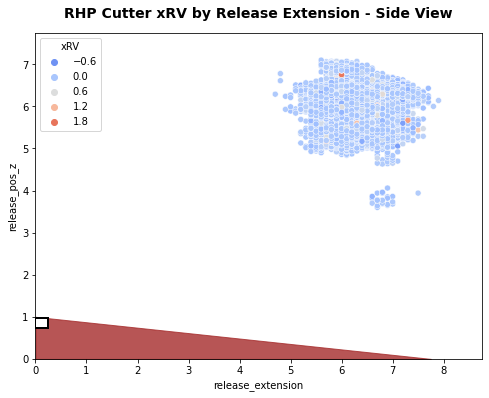

In [27]:
plt.figure(figsize = (8, 6))

sns.scatterplot(data = fc_r, x = 'release_extension', y = 'release_pos_z', hue = 'xRV', palette = 'coolwarm')
plt.xlim(0, 8.75), plt.ylim(0, 7.75)
plt.gca().add_patch(Rectangle((0, .74), .24, .24, fill = True, fc = 'white', ec = 'black', linewidth = 2))
plt.fill_between((7.75, 0), (0, 1), color = 'brown', alpha = .8)
plt.title('RHP Cutter xRV by Release Extension - Side View', fontsize = 14, fontweight = 'bold', pad = 15);

### RHP Cutter xRV by Release Point

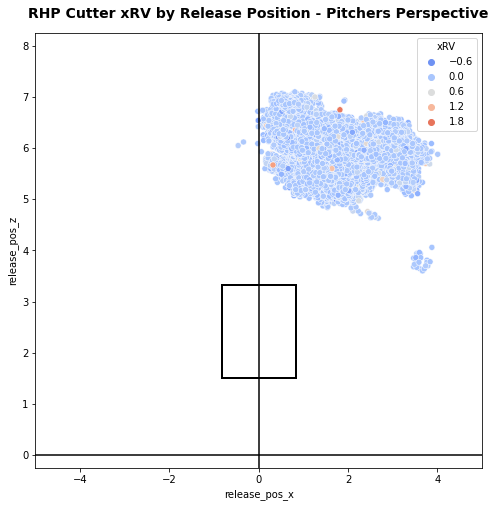

In [28]:
plt.figure(figsize = (8, 8))

sns.scatterplot(data = fc_r, x = 'release_pos_x', y = 'release_pos_z', hue = 'xRV', palette = 'coolwarm')
plt.xlim(-5, 5), plt.ylim(-0.25, 8.25)
plt.axvline(0, color = 'black'), plt.axhline(0, color = 'black')
plt.gca().add_patch(Rectangle((-.83, 1.5), 1.66, 1.82, fill = False, color = 'black', linewidth = 2))
plt.title('RHP Cutter xRV by Release Position - Pitchers Perspective', fontsize = 14, fontweight = 'bold',pad=15);

### RHP Cutter xRV by Velo & Spin Rate

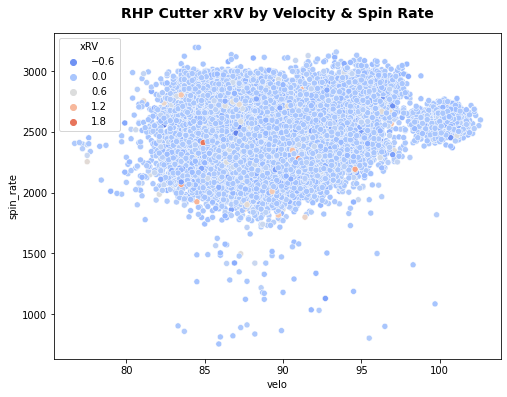

In [29]:
plt.figure(figsize = (8, 6))

sns.scatterplot(data = fc_r, x = 'velo', y = 'spin_rate', hue = 'xRV', palette = 'coolwarm')
plt.title('RHP Cutter xRV by Velocity & Spin Rate', fontsize = 14, fontweight = 'bold', pad = 15);

## Cutter LHP

In [30]:
print('Baseline LHP Cutter RunValue Accuracy Score:', round(fc_l.rv.mean(), 2))

Baseline LHP Cutter RunValue Accuracy Score: 0.0


In [31]:
features_fc_l = fc_l.select_dtypes([np.number])
X = features_fc_l.drop(columns = ['rv'])
y = features_fc_l['rv']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 1)

rf = RandomForestRegressor(random_state = 1).fit(X_train, y_train)
pred_fc_l = rf.predict(X_test)
pred = rf.predict(X)

print('R2 Test Score:', round((metrics.r2_score(y_test, pred_fc_l)), 3))
print('Test RMSE:', round(np.sqrt(metrics.mean_squared_error(y_test, pred_fc_l)), 3))
print('Test MAE:', round(metrics.mean_absolute_error(y_test, pred_fc_l), 3), '\n')
print('R2 Score:', round((metrics.r2_score(y, pred)), 3))
print('RMSE:', round(np.sqrt(metrics.mean_squared_error(y, pred)), 3))
print('MAE:', round(metrics.mean_absolute_error(y, pred), 3))

R2 Test Score: -0.048
Test RMSE: 0.273
Test MAE: 0.135 

R2 Score: 0.616
RMSE: 0.162
MAE: 0.073


### LHP Cutter Actual & Predicted Values

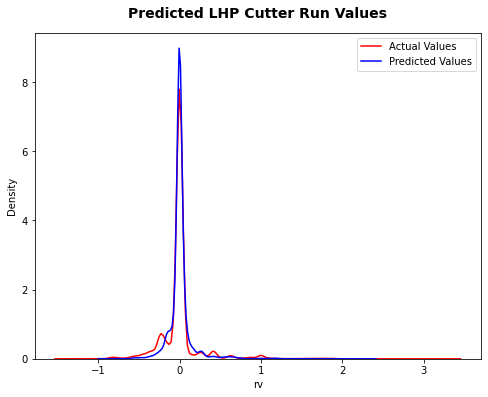

In [32]:
plt.figure(figsize = (8, 6))

ax = sns.distplot(y, hist = False, color = 'r', label = 'Actual Values')
sns.distplot(pred, hist = False, color = 'b', label = 'Predicted Values', ax = ax)
plt.legend()
plt.title('Predicted LHP Cutter Run Values', fontsize = 14, fontweight = 'bold', pad = 15);

### LHP Cutter RV Table

In [33]:
fc_l['n_pitches'] = [1 if x == 'FC' else 0 for x in fc_l['pitch_type']]
fc_l['xRV'] = pred
grouped_fc_l = fc_l.groupby(['player_name', 'pitch_type'], 
                            as_index = False)['n_pitches', 'velo', 'pfx_x', 'pfx_z', 'spin_rate', 
                                              'release_pos_x', 'release_pos_z', 'arm_angle', 'rv', 'xRV'].sum()
grouped_fc_l['RV/100'] = round(((grouped_fc_l['rv'] / grouped_fc_l['n_pitches']) * 100), 2)
grouped_fc_l['xRV/100'] = round(((grouped_fc_l['xRV'] / grouped_fc_l['n_pitches']) * 100), 2)

fc_l_group = pd.merge(fc_l, grouped_fc_l, how = 'left', on = ['player_name'])
fc_l_group.drop(columns = drop_cols, inplace = True)
fc_l_group.rename(columns = col_dict, inplace = True)
fc_l_rv_table = fc_l_group.groupby(['player_name', 'p_throws', 'pitch_type'], 
                                   as_index = False)['n_pitches', 'velo', 'HB', 'VB', 'spin_rate',
                                                     'release_pos_x', 'release_pos_z', 'arm_angle',
                                                     'RV', 'RV/100', 'xRV', 'xRV/100'].mean()
fc_l_rv_table = fc_l_rv_table.round(1)
print(fc_l_rv_table.shape)
fc_l_rv_table.head()

(61, 15)


,player_name,p_throws,pitch_type,n_pitches,velo,HB,VB,spin_rate,release_pos_x,release_pos_z,arm_angle,RV,RV/100,xRV,xRV/100
0,"Abad, Fernando",L,FC,16.0,82.6,3.4,2.7,2310.4,-1.1,6.0,32.2,0.2,1.2,0.5,3.1
1,"Alexander, Tyler",L,FC,581.0,86.2,3.7,8.5,2334.9,-2.1,5.7,69.6,-1.8,-0.3,-0.6,-0.1
2,"Allard, Kolby",L,FC,507.0,86.3,2.4,6.0,2196.6,-2.2,5.5,76.1,12.4,2.4,8.4,1.6
3,"Alvarado, José",L,FC,170.0,94.1,1.3,5.1,2255.7,-1.0,6.4,25.5,-9.1,-5.3,-8.3,-4.9
4,"Anderson, Brett",L,FC,117.0,85.7,0.7,9.5,2035.9,-1.4,6.2,41.0,1.0,0.8,2.5,2.1


### LHP Cutter xRV by HB & VB

LHP Cutter Avg xRunValue: 0.01


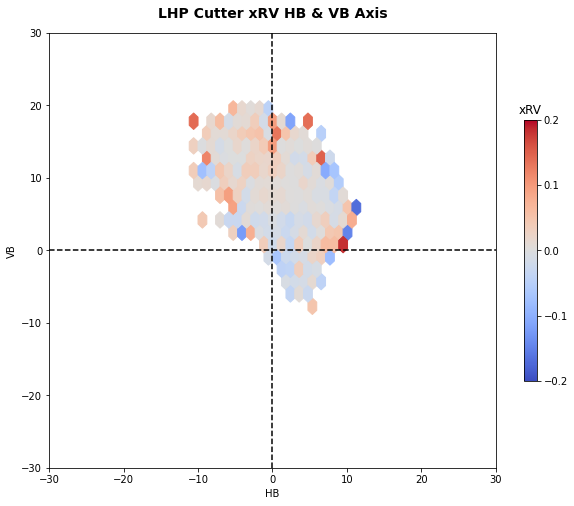

In [34]:
plt.figure(figsize = (10, 8))

plt.hexbin(fc_l['pfx_x'], fc_l['pfx_z'], C = fc_l['xRV'], cmap = 'coolwarm', mincnt = 1, gridsize = 20)
cb = plt.colorbar(ticks = [-.2,-.1, 0, .1, .2], shrink = .6)
cb.ax.set_title('xRV'), plt.clim(-.2, .2)
plt.xlabel('HB'), plt.ylabel('VB'), plt.xlim(-30, 30), plt.ylim(-30, 30)
plt.axhline(0, color = 'black', ls = '--'), plt.axvline(0, color = 'black', ls = '--')
plt.title('LHP Cutter xRV HB & VB Axis', fontsize = 14, fontweight = 'bold', pad = 15);
print('LHP Cutter Avg xRunValue:', round(fc_l.xRV.mean(), 2))

### LHP Cutter xRV by Release Extension

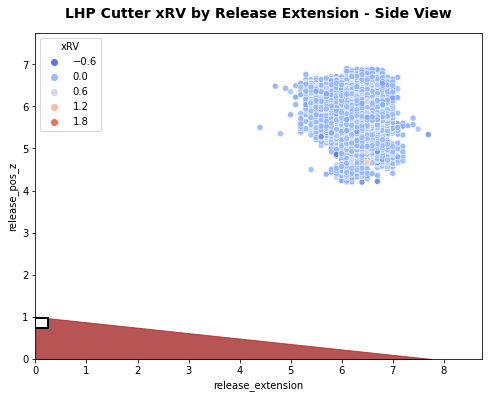

In [35]:
plt.figure(figsize = (8, 6))

sns.scatterplot(data = fc_l, x = 'release_extension', y = 'release_pos_z', hue = 'xRV', palette = 'coolwarm')
plt.xlim(0, 8.75), plt.ylim(0, 7.75)
plt.gca().add_patch(Rectangle((0, .74), .24, .24, fill = True, fc = 'white', ec = 'black', linewidth = 2))
plt.fill_between((7.75, 0), (0, 1), color = 'brown', alpha = .8)
plt.title('LHP Cutter xRV by Release Extension - Side View', fontsize = 14, fontweight = 'bold', pad = 15);

### LHP Cutter xRV by Release Point

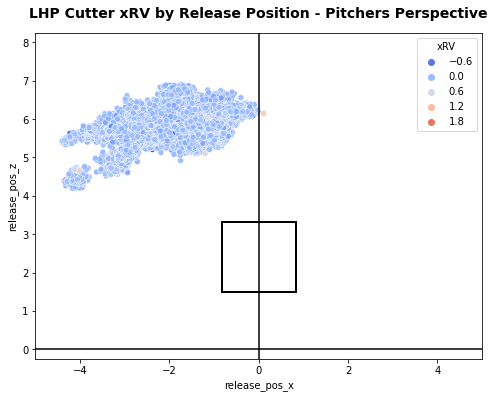

In [36]:
plt.figure(figsize = (8, 6))

sns.scatterplot(data = fc_l, x = 'release_pos_x', y = 'release_pos_z', hue = 'xRV', palette = 'coolwarm')
plt.xlim(-5, 5), plt.ylim(-0.25, 8.25)
plt.axvline(0, color = 'black'), plt.axhline(0, color = 'black')
plt.gca().add_patch(Rectangle((-.83, 1.5), 1.66, 1.82, fill = False, color = 'black', linewidth = 2))
plt.title('LHP Cutter xRV by Release Position - Pitchers Perspective', fontsize = 14, fontweight = 'bold',pad=15);

### LHP Cutter xRV by Velo & Spin Rate

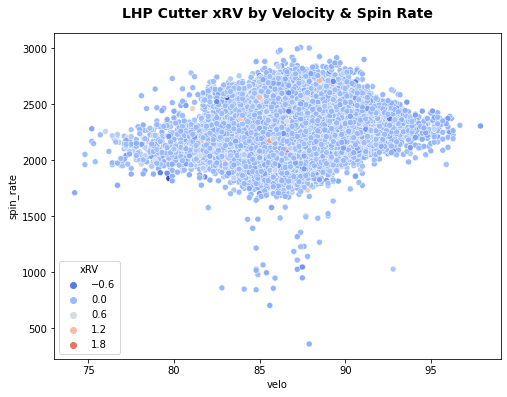

In [37]:
plt.figure(figsize = (8, 6))

sns.scatterplot(data = fc_l, x = 'velo', y = 'spin_rate', hue = 'xRV', palette = 'coolwarm')
plt.title('LHP Cutter xRV by Velocity & Spin Rate', fontsize = 14, fontweight = 'bold', pad = 15);

## Sinker RHP

In [38]:
print('Baseline RHP Sinker RunValue Accuracy Score:', round(si_r.rv.mean(), 2))

Baseline RHP Sinker RunValue Accuracy Score: 0.01


In [39]:
features_si_r = si_r.select_dtypes([np.number])
X = features_si_r.drop(columns = ['rv'])
y = features_si_r['rv']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 1)

rf = RandomForestRegressor(random_state = 1).fit(X_train, y_train)
pred_si_r = rf.predict(X_test)
pred = rf.predict(X)

print('R2 Test Score:', round((metrics.r2_score(y_test, pred_si_r)), 3))
print('Test RMSE:', round(np.sqrt(metrics.mean_squared_error(y_test, pred_si_r)), 3))
print('Test MAE:', round(metrics.mean_absolute_error(y_test, pred_si_r), 3), '\n')
print('R2 Score:', round((metrics.r2_score(y, pred)), 3))
print('RMSE:', round(np.sqrt(metrics.mean_squared_error(y, pred)), 3))
print('MAE:', round(metrics.mean_absolute_error(y, pred), 3))

R2 Test Score: -0.038
Test RMSE: 0.273
Test MAE: 0.138 

R2 Score: 0.627
RMSE: 0.162
MAE: 0.074


### RHP Sinker Actual & Predicted Values

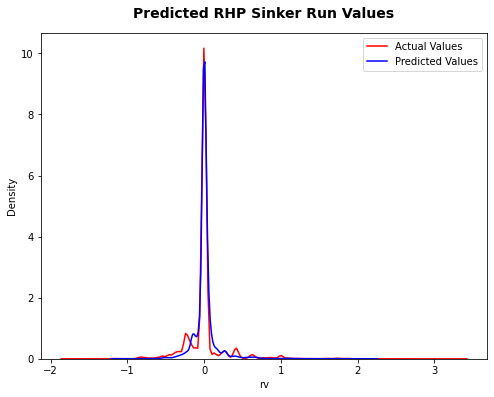

In [40]:
plt.figure(figsize = (8, 6))

ax = sns.distplot(y, hist = False, color = 'r', label = 'Actual Values')
sns.distplot(pred, hist = False, color = 'b', label = 'Predicted Values', ax = ax)
plt.legend()
plt.title('Predicted RHP Sinker Run Values', fontsize = 14, fontweight = 'bold', pad = 15);

### RHP Sinker RV Table

In [41]:
si_r['n_pitches'] = [1 if x == 'SI' else 0 for x in si_r['pitch_type']]
si_r['xRV'] = pred
grouped_si_r = si_r.groupby(['player_name', 'pitch_type'], 
                            as_index = False)['n_pitches', 'velo', 'pfx_x', 'pfx_z', 'spin_rate', 
                                              'release_pos_x', 'release_pos_z', 'arm_angle', 'rv', 'xRV'].sum()
grouped_si_r['RV/100'] = round(((grouped_si_r['rv'] / grouped_si_r['n_pitches']) * 100), 2)
grouped_si_r['xRV/100'] = round(((grouped_si_r['xRV'] / grouped_si_r['n_pitches']) * 100), 2)

si_r_group = pd.merge(si_r, grouped_si_r, how = 'left', on = ['player_name'])
si_r_group.drop(columns = drop_cols, inplace = True)
si_r_group.rename(columns = col_dict, inplace = True)
si_r_rv_table = si_r_group.groupby(['player_name', 'p_throws', 'pitch_type'], 
                                   as_index = False)['n_pitches', 'velo', 'HB', 'VB', 'spin_rate',
                                                     'release_pos_x', 'release_pos_z', 'arm_angle',
                                                     'RV', 'RV/100', 'xRV', 'xRV/100'].mean()
si_r_rv_table = si_r_rv_table.round(1)
print(si_r_rv_table.shape)
si_r_rv_table.head()

(357, 15)


,player_name,p_throws,pitch_type,n_pitches,velo,HB,VB,spin_rate,release_pos_x,release_pos_z,arm_angle,RV,RV/100,xRV,xRV/100
0,"Abreu, Albert",R,SI,212.0,98.0,15.3,13.3,2155.2,2.5,5.6,41.0,3.2,1.5,4.9,2.3
1,"Abreu, Bryan",R,SI,2.0,96.0,14.2,14.9,2277.5,1.9,5.9,33.5,0.0,0.0,-0.0,-0.8
2,"Adon, Joan",R,SI,1.0,97.2,14.8,15.5,2254.0,2.9,6.1,42.8,0.0,0.0,0.0,0.3
3,"Alaniz, R.J.",R,SI,37.0,92.8,16.9,9.9,2126.1,2.2,5.6,39.0,0.8,2.2,0.7,1.8
4,"Alcala, Jorge",R,SI,52.0,97.2,16.5,10.3,2191.5,2.6,6.5,38.6,1.4,2.8,0.9,1.8


### RHP Sinker xRV by HB & VB

RHP Sinker Avg xRunValue: 0.01


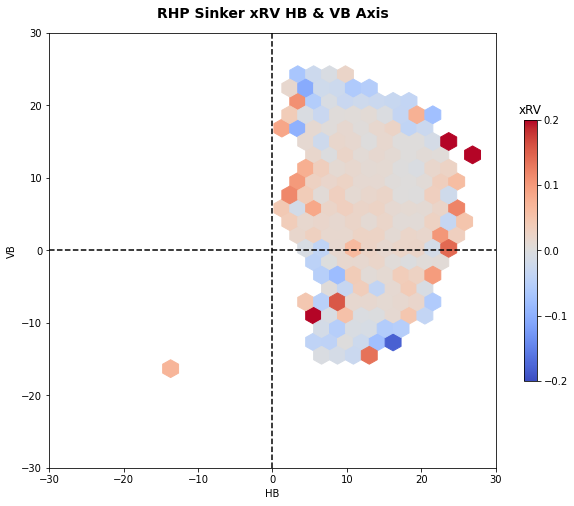

In [42]:
plt.figure(figsize = (10, 8))

plt.hexbin(si_r['pfx_x'], si_r['pfx_z'], C = si_r['xRV'], cmap = 'coolwarm', mincnt = 1, gridsize = 20)
cb = plt.colorbar(ticks = [-.2,-.1, 0, .1, .2], shrink = .6)
cb.ax.set_title('xRV'), plt.clim(-.2, .2)
plt.xlabel('HB'), plt.ylabel('VB'), plt.xlim(-30, 30), plt.ylim(-30, 30)
plt.axhline(0, color = 'black', ls = '--'), plt.axvline(0, color = 'black', ls = '--')
plt.title('RHP Sinker xRV HB & VB Axis', fontsize = 14, fontweight = 'bold', pad = 15);
print('RHP Sinker Avg xRunValue:', round(si_r.xRV.mean(), 2))

### RHP Sinker xRV by Release Extension

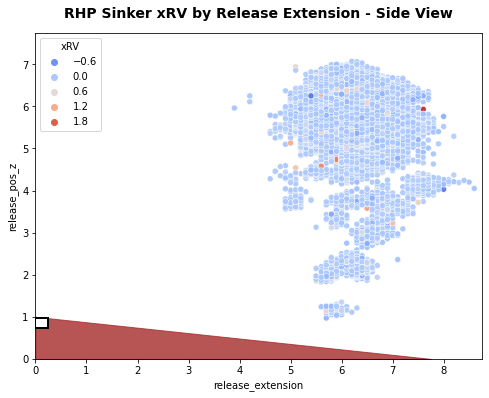

In [43]:
plt.figure(figsize = (8, 6))

sns.scatterplot(data = si_r, x = 'release_extension', y = 'release_pos_z', hue = 'xRV', palette = 'coolwarm')
plt.xlim(0, 8.75), plt.ylim(0, 7.75)
plt.gca().add_patch(Rectangle((0, .74), .24, .24, fill = True, fc = 'white', ec = 'black', linewidth = 2))
plt.fill_between((7.75, 0), (0, 1), color = 'brown', alpha = .8)
plt.title('RHP Sinker xRV by Release Extension - Side View', fontsize = 14, fontweight = 'bold', pad = 15);

### RHP Sinker xRV by Release Point

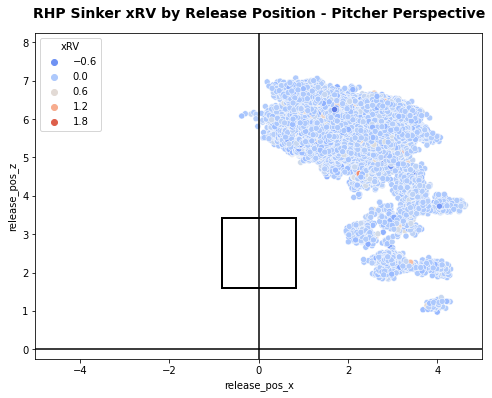

In [44]:
plt.figure(figsize = (8, 6))

sns.scatterplot(data = si_r, x = 'release_pos_x', y = 'release_pos_z', hue = 'xRV', palette = 'coolwarm')
plt.xlim(-5, 5), plt.ylim(-0.25, 8.25)
plt.axvline(0, color = 'black'), plt.axhline(0, color = 'black')
left, bottom, width, height = (-.83, 1.59, 1.66, 1.82)
plt.gca().add_patch(Rectangle((left, bottom), width, height, fill = False, color = 'black', linewidth = 2))
plt.title('RHP Sinker xRV by Release Position - Pitcher Perspective', fontsize = 14, fontweight = 'bold', pad=15);

### RHP Sinker xRV by Velo & Spin Rate

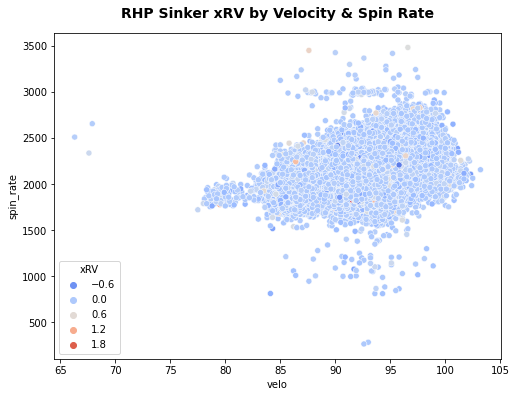

In [45]:
plt.figure(figsize = (8, 6))

sns.scatterplot(data = si_r, x = 'velo', y = 'spin_rate', hue = 'xRV', palette = 'coolwarm')
plt.title('RHP Sinker xRV by Velocity & Spin Rate', fontsize = 14, fontweight = 'bold', pad = 15);

## Sinker LHP

In [46]:
print('Baseline LHP Sinker RunValue Accuracy Score:', round(si_l.rv.mean(), 2))

Baseline LHP Sinker RunValue Accuracy Score: 0.01


In [47]:
features_si_l = si_l.select_dtypes([np.number])
X = features_si_l.drop(columns = ['rv'])
y = features_si_l['rv']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 1)

rf = RandomForestRegressor(random_state = 1).fit(X_train, y_train)
pred_si_l = rf.predict(X_test)
pred = rf.predict(X)

print('R2 Test Score:', round((metrics.r2_score(y_test, pred_si_l)), 3))
print('Test RMSE:', round(np.sqrt(metrics.mean_squared_error(y_test, pred_si_l)), 3))
print('Test MAE:', round(metrics.mean_absolute_error(y_test, pred_si_l), 3), '\n')
print('R2 Score:', round((metrics.r2_score(y, pred)), 3))
print('RMSE:', round(np.sqrt(metrics.mean_squared_error(y, pred)), 3))
print('MAE:', round(metrics.mean_absolute_error(y, pred), 3))

R2 Test Score: -0.064
Test RMSE: 0.26
Test MAE: 0.134 

R2 Score: 0.632
RMSE: 0.156
MAE: 0.073


### LHP Sinker Actual & Predicted Values

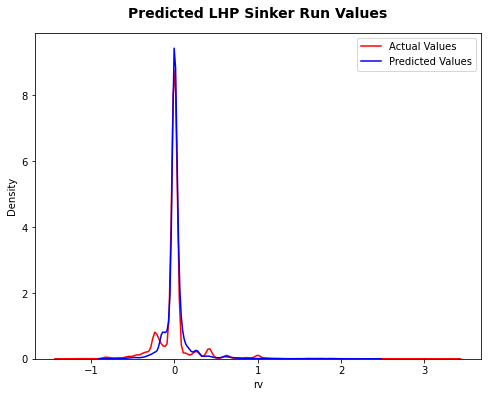

In [48]:
plt.figure(figsize = (8, 6))

ax = sns.distplot(y, hist = False, color = 'r', label = 'Actual Values')
sns.distplot(pred, hist = False, color = 'b', label = 'Predicted Values', ax = ax)
plt.legend()
plt.title('Predicted LHP Sinker Run Values', fontsize = 14, fontweight = 'bold', pad = 15);

### LHP Sinker RV Table

In [49]:
si_l['n_pitches'] = [1 if x == 'SI' else 0 for x in si_l['pitch_type']]
si_l['xRV'] = pred
grouped_si_l = si_l.groupby(['player_name', 'pitch_type'], 
                            as_index = False)['n_pitches', 'velo', 'pfx_x', 'pfx_z', 'spin_rate', 
                                              'release_pos_x', 'release_pos_z', 'arm_angle', 'rv', 'xRV'].sum()
grouped_si_l['RV/100'] = round(((grouped_si_l['rv'] / grouped_si_l['n_pitches']) * 100), 2)
grouped_si_l['xRV/100'] = round(((grouped_si_l['xRV'] / grouped_si_l['n_pitches']) * 100), 2)

si_l_group = pd.merge(si_l, grouped_si_l, how = 'left', on = ['player_name'])
si_l_group.drop(columns = drop_cols, inplace = True)
si_l_group.rename(columns = col_dict, inplace = True)
si_l_rv_table = si_l_group.groupby(['player_name', 'p_throws', 'pitch_type'], 
                                   as_index = False)['n_pitches', 'velo', 'HB', 'VB', 'spin_rate',
                                                     'release_pos_x', 'release_pos_z', 'arm_angle',
                                                     'RV', 'RV/100', 'xRV', 'xRV/100'].mean()
si_l_rv_table = si_l_rv_table.round(1)
print(si_l_rv_table.shape)
si_l_rv_table.head()

(152, 15)


,player_name,p_throws,pitch_type,n_pitches,velo,HB,VB,spin_rate,release_pos_x,release_pos_z,arm_angle,RV,RV/100,xRV,xRV/100
0,"Abad, Fernando",L,SI,141.0,92.4,-13.2,12.9,2144.5,-0.6,6.3,13.9,-1.4,-1.0,1.4,1.0
1,"Albers, Andrew",L,SI,117.0,88.3,-13.3,15.1,2037.6,-1.7,5.8,51.6,1.3,1.1,3.4,2.9
2,"Alexander, Scott",L,SI,192.0,92.2,-14.1,4.9,2188.4,-1.8,5.7,59.4,1.0,0.5,3.0,1.6
3,"Alexander, Tyler",L,SI,337.0,90.2,-14.5,13.2,2107.7,-2.0,5.8,65.8,4.5,1.3,8.0,2.4
4,"Allard, Kolby",L,SI,8.0,92.5,-13.3,16.4,2198.5,-2.2,5.5,74.3,-0.1,-1.4,-0.0,-0.1


### LHP Sinker xRV by HB & VB

LHP Sinker Avg xRunValue: 0.01


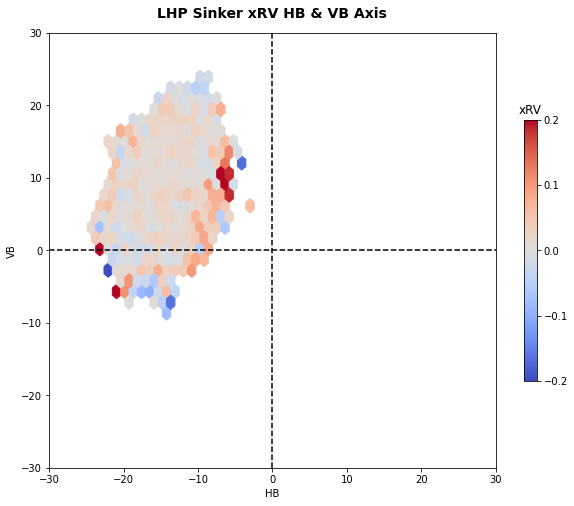

In [50]:
plt.figure(figsize = (10, 8))

plt.hexbin(si_l['pfx_x'], si_l['pfx_z'], C = si_l['xRV'], cmap = 'coolwarm', mincnt = 1, gridsize = 20)
cb = plt.colorbar(ticks = [-.2,-.1, 0, .1, .2], shrink = .6)
cb.ax.set_title('xRV'), plt.clim(-.2, .2)
plt.xlabel('HB'), plt.ylabel('VB'), plt.xlim(-30, 30), plt.ylim(-30, 30)
plt.axhline(0, color = 'black', ls = '--'), plt.axvline(0, color = 'black', ls = '--')
plt.title('LHP Sinker xRV HB & VB Axis', fontsize = 14, fontweight = 'bold', pad = 15);
print('LHP Sinker Avg xRunValue:', round(si_l.xRV.mean(), 2))

### LHP Sinker xRV by Release Extension

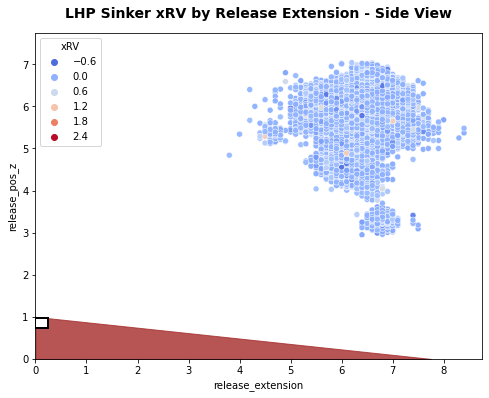

In [51]:
plt.figure(figsize = (8, 6))

sns.scatterplot(data = si_l, x = 'release_extension', y = 'release_pos_z', hue = 'xRV', palette = 'coolwarm')
plt.xlim(0, 8.75), plt.ylim(0, 7.75)
plt.gca().add_patch(Rectangle((0, .74), .24, .24, fill = True, fc = 'white', ec = 'black', linewidth = 2))
plt.fill_between((7.75, 0), (0, 1), color = 'brown', alpha = .8)
plt.title('LHP Sinker xRV by Release Extension - Side View', fontsize = 14, fontweight = 'bold', pad = 15);

### LHP Sinker xRV by Release Point

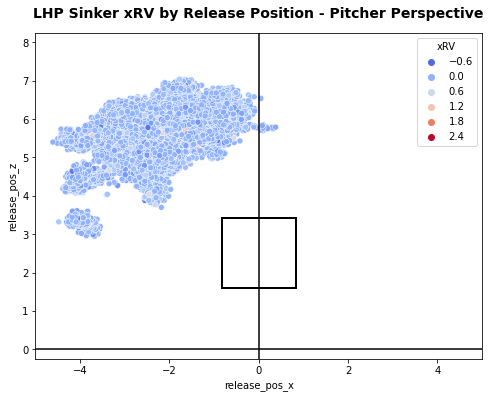

In [52]:
plt.figure(figsize = (8, 6))

sns.scatterplot(data = si_l, x = 'release_pos_x', y = 'release_pos_z', hue = 'xRV', palette = 'coolwarm')
plt.xlim(-5, 5), plt.ylim(-0.25, 8.25)
plt.axvline(0, color = 'black'), plt.axhline(0, color = 'black')
left, bottom, width, height = (-.83, 1.59, 1.66, 1.82)
plt.gca().add_patch(Rectangle((left, bottom), width, height, fill = False, color = 'black', linewidth = 2))
plt.title('LHP Sinker xRV by Release Position - Pitcher Perspective', fontsize = 14, fontweight = 'bold', pad=15);

### LHP Sinker xRV by Velo & Spin Rate

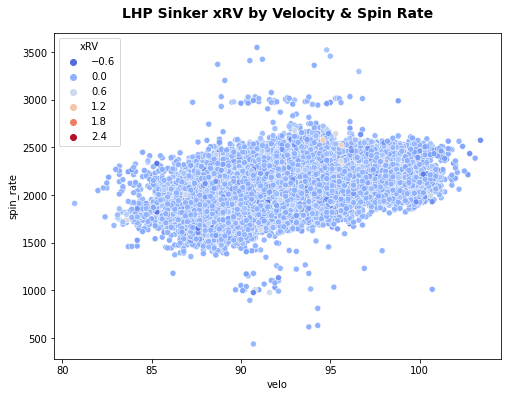

In [53]:
plt.figure(figsize = (8, 6))

sns.scatterplot(data = si_l, x = 'velo', y = 'spin_rate', hue = 'xRV', palette = 'coolwarm')
plt.title('LHP Sinker xRV by Velocity & Spin Rate', fontsize = 14, fontweight = 'bold', pad = 15);

## Slider RHP

In [54]:
print('Baseline RHP Slider RunValue Accuracy Score:', round(sl_r.rv.mean(), 2))

Baseline RHP Slider RunValue Accuracy Score: -0.01


In [55]:
features_sl_r = sl_r.select_dtypes([np.number])
X = features_sl_r.drop(columns = ['rv'])
y = features_sl_r['rv']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 1)

rf = RandomForestRegressor(random_state = 1).fit(X_train, y_train)
pred_sl_r = rf.predict(X_test)
pred = rf.predict(X)

print('R2 Test Score:', round((metrics.r2_score(y_test, pred_sl_r)), 3))
print('Test RMSE:', round(np.sqrt(metrics.mean_squared_error(y_test, pred_sl_r)), 3))
print('Test MAE:', round(metrics.mean_absolute_error(y_test, pred_sl_r), 3), '\n')
print('R2 Score:', round((metrics.r2_score(y, pred)), 3))
print('RMSE:', round(np.sqrt(metrics.mean_squared_error(y, pred)), 3))
print('MAE:', round(metrics.mean_absolute_error(y, pred), 3))

R2 Test Score: -0.039
Test RMSE: 0.263
Test MAE: 0.128 

R2 Score: 0.625
RMSE: 0.156
MAE: 0.069


### RHP Slider Actual & Predicted Values

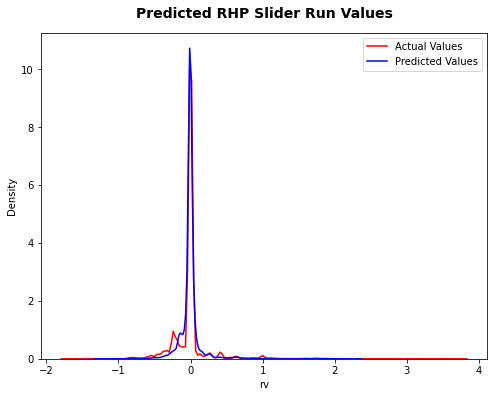

In [56]:
plt.figure(figsize = (8, 6))

ax = sns.distplot(y, hist = False, color = 'r', label = 'Actual Values')
sns.distplot(pred, hist = False, color = 'b', label = 'Predicted Values', ax = ax)
plt.legend()
plt.title('Predicted RHP Slider Run Values', fontsize = 14, fontweight = 'bold', pad = 15);

### RHP Slider RV Table

In [57]:
sl_r['n_pitches'] = [1 if x == 'SL' else 0 for x in sl_r['pitch_type']]
sl_r['xRV'] = pred
grouped_sl_r = sl_r.groupby(['player_name', 'pitch_type'], 
                            as_index = False)['n_pitches', 'velo', 'pfx_x', 'pfx_z', 'spin_rate', 
                                              'release_pos_x', 'release_pos_z', 'arm_angle', 'rv', 'xRV'].sum()
grouped_sl_r['RV/100'] = round(((grouped_sl_r['rv'] / grouped_sl_r['n_pitches']) * 100), 2)
grouped_sl_r['xRV/100'] = round(((grouped_sl_r['xRV'] / grouped_sl_r['n_pitches']) * 100), 2)

sl_r_group = pd.merge(sl_r, grouped_sl_r, how = 'left', on = ['player_name'])
sl_r_group.drop(columns = drop_cols, inplace = True)
sl_r_group.rename(columns = col_dict, inplace = True)
sl_r_rv_table = sl_r_group.groupby(['player_name', 'p_throws', 'pitch_type'], 
                                   as_index = False)['n_pitches', 'velo', 'HB', 'VB', 'spin_rate',
                                                     'release_pos_x', 'release_pos_z', 'arm_angle',
                                                     'RV', 'RV/100', 'xRV', 'xRV/100'].mean()
sl_r_rv_table = sl_r_rv_table.round(1)
print(sl_r_rv_table.shape)
sl_r_rv_table.head()

(513, 15)


,player_name,p_throws,pitch_type,n_pitches,velo,HB,VB,spin_rate,release_pos_x,release_pos_z,arm_angle,RV,RV/100,xRV,xRV/100
0,"Abbott, Cory",R,SL,63.0,87.7,6.6,3.5,2200.5,2.7,5.7,42.7,2.0,3.2,4.3,6.9
1,"Abreu, Albert",R,SL,224.0,87.3,-2.8,3.5,2209.4,2.6,5.7,41.5,-3.0,-1.3,-2.2,-1.0
2,"Abreu, Bryan",R,SL,256.0,88.9,-3.7,-2.2,2526.4,2.0,5.7,35.1,5.8,2.3,2.8,1.1
3,"Acevedo, Domingo",R,SL,49.0,85.1,5.6,7.3,2138.0,2.0,5.8,35.3,-3.5,-7.1,-2.3,-4.7
4,"Adam, Jason",R,SL,39.0,82.4,-6.7,-6.2,2763.3,1.8,6.0,31.9,-1.6,-4.2,-0.5,-1.3


### RHP Slider xRV by HB & VB

RHP Slider Avg xRunValue: -0.01


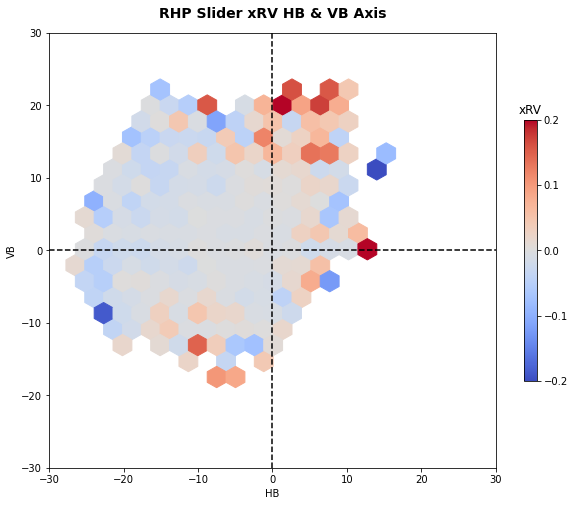

In [58]:
plt.figure(figsize = (10, 8))
plt.hexbin(sl_r['pfx_x'], sl_r['pfx_z'], C = sl_r['xRV'], cmap = 'coolwarm', mincnt = 1, gridsize = 20)
cb = plt.colorbar(ticks = [-.2,-.1, 0, .1, .2], shrink = .6)
cb.ax.set_title('xRV'), plt.clim(-.2, .2)
plt.xlabel('HB'), plt.ylabel('VB'), plt.xlim(-30, 30), plt.ylim(-30, 30)
plt.axhline(0, color = 'black', ls = '--'), plt.axvline(0, color = 'black', ls = '--')
plt.title('RHP Slider xRV HB & VB Axis', fontsize = 14, fontweight = 'bold', pad = 15);
print('RHP Slider Avg xRunValue:', round(sl_r.xRV.mean(), 2))

### RHP Slider xRV by Release Extension

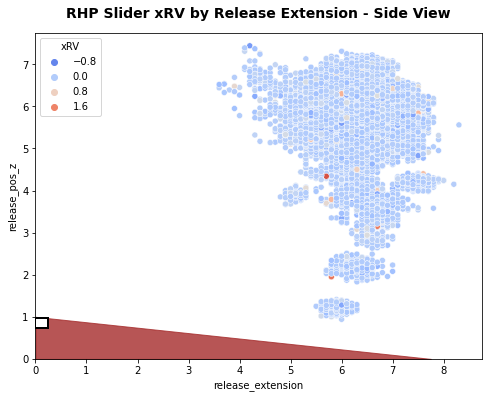

In [59]:
plt.figure(figsize = (8, 6))

sns.scatterplot(data = sl_r, x = 'release_extension', y = 'release_pos_z', hue = 'xRV', palette = 'coolwarm')
plt.xlim(0, 8.75), plt.ylim(0, 7.75)
plt.gca().add_patch(Rectangle((0, .74), .24, .24, fill = True, fc = 'white', ec = 'black', linewidth = 2))
plt.fill_between((7.75, 0), (0, 1), color = 'brown', alpha = .8)
plt.title('RHP Slider xRV by Release Extension - Side View', fontsize = 14, fontweight = 'bold', pad = 15);

### RHP Slider xRV by Release Point

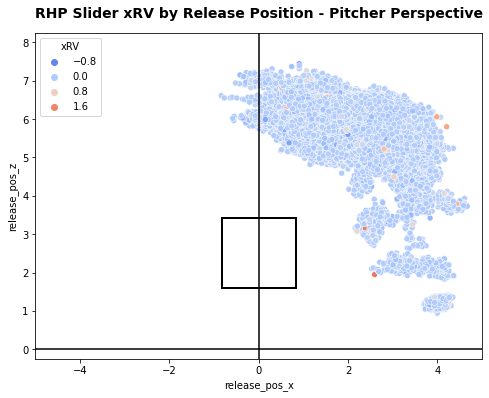

In [60]:
plt.figure(figsize = (8, 6))

sns.scatterplot(data = sl_r, x = 'release_pos_x', y = 'release_pos_z', hue = 'xRV', palette = 'coolwarm')
plt.xlim(-5, 5), plt.ylim(-0.25, 8.25)
plt.axvline(0, color = 'black'), plt.axhline(0, color = 'black')
left, bottom, width, height = (-.83, 1.59, 1.66, 1.82)
plt.gca().add_patch(Rectangle((left, bottom), width, height, fill = False, color = 'black', linewidth = 2))
plt.title('RHP Slider xRV by Release Position - Pitcher Perspective', fontsize = 14, fontweight = 'bold', pad=15);

### RHP Slider xRV by Velo & Spin Rate

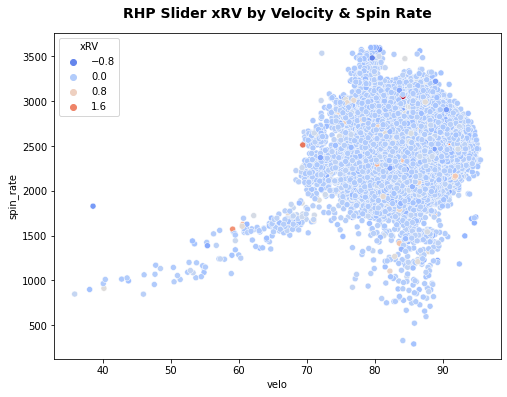

In [61]:
plt.figure(figsize = (8, 6))

sns.scatterplot(data = sl_r, x = 'velo', y = 'spin_rate', hue = 'xRV', palette = 'coolwarm')
plt.title('RHP Slider xRV by Velocity & Spin Rate', fontsize = 14, fontweight = 'bold', pad = 15);

## Slider LHP

In [62]:
print('Baseline LHP Slider RunValue Accuracy Score:', round(sl_l.rv.mean(), 2))

Baseline LHP Slider RunValue Accuracy Score: -0.01


In [63]:
features_sl_l = sl_l.select_dtypes([np.number])
X = features_sl_l.drop(columns = ['rv'])
y = features_sl_l['rv']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 1)

rf = RandomForestRegressor(random_state = 1).fit(X_train, y_train)
pred_sl_l = rf.predict(X_test)
pred = rf.predict(X)

print('R2 Test Score:', round((metrics.r2_score(y_test, pred_sl_l)), 3))
print('Test RMSE:', round(np.sqrt(metrics.mean_squared_error(y_test, pred_sl_l)), 3))
print('Test MAE:', round(metrics.mean_absolute_error(y_test, pred_sl_l), 3), '\n')
print('R2 Score:', round((metrics.r2_score(y, pred)), 3))
print('RMSE:', round(np.sqrt(metrics.mean_squared_error(y, pred)), 3))
print('MAE:', round(metrics.mean_absolute_error(y, pred), 3))

R2 Test Score: -0.052
Test RMSE: 0.27
Test MAE: 0.133 

R2 Score: 0.616
RMSE: 0.16
MAE: 0.071


### LHP Slider Actual & Predicted Values

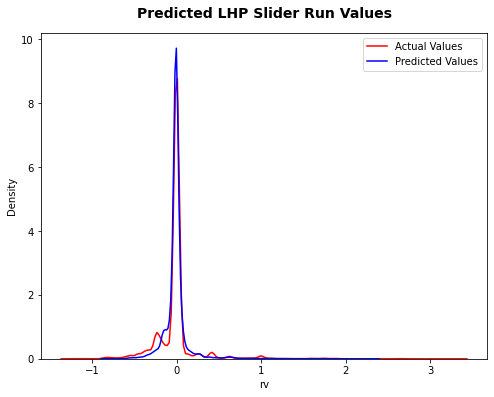

In [64]:
plt.figure(figsize = (8, 6))

ax = sns.distplot(y, hist = False, color = 'r', label = 'Actual Values')
sns.distplot(pred, hist = False, color = 'b', label = 'Predicted Values', ax = ax)
plt.legend()
plt.title('Predicted LHP Slider Run Values', fontsize = 14, fontweight = 'bold', pad = 15);

### LHP Slider RV Table

In [65]:
sl_l['n_pitches'] = [1 if x == 'SL' else 0 for x in sl_l['pitch_type']]
sl_l['xRV'] = pred
grouped_sl_l = sl_l.groupby(['player_name', 'pitch_type'], 
                            as_index = False)['n_pitches', 'velo', 'pfx_x', 'pfx_z', 'spin_rate', 
                                              'release_pos_x', 'release_pos_z', 'arm_angle', 'rv', 'xRV'].sum()
grouped_sl_l['RV/100'] = round(((grouped_sl_l['rv'] / grouped_sl_l['n_pitches']) * 100), 2)
grouped_sl_l['xRV/100'] = round(((grouped_sl_l['xRV'] / grouped_sl_l['n_pitches']) * 100), 2)

sl_l_group = pd.merge(sl_l, grouped_sl_l, how = 'left', on = ['player_name'])
sl_l_group.drop(columns = drop_cols, inplace = True)
sl_l_group.rename(columns = col_dict, inplace = True)
sl_l_rv_table = sl_l_group.groupby(['player_name', 'p_throws', 'pitch_type'], 
                                   as_index = False)['n_pitches', 'velo', 'HB', 'VB', 'spin_rate',
                                                     'release_pos_x', 'release_pos_z', 'arm_angle',
                                                     'RV', 'RV/100', 'xRV', 'xRV/100'].mean()
sl_l_rv_table = sl_l_rv_table.round(1)
print(sl_l_rv_table.shape)
sl_l_rv_table.head()

(175, 15)


,player_name,p_throws,pitch_type,n_pitches,velo,HB,VB,spin_rate,release_pos_x,release_pos_z,arm_angle,RV,RV/100,xRV,xRV/100
0,"Aguilar, Miguel",L,SL,20.0,85.9,5.3,5.2,2387.4,-1.1,5.4,34.3,1.9,9.4,1.6,7.9
1,"Akin, Keegan",L,SL,344.0,84.2,4.5,3.2,2215.2,-2.5,5.7,84.5,9.3,2.7,6.9,2.0
2,"Albers, Andrew",L,SL,54.0,78.1,2.6,-1.3,2299.2,-1.4,5.9,41.4,0.8,1.6,4.2,7.7
3,"Alexander, Scott",L,SL,45.0,84.3,3.9,-4.2,2449.1,-1.8,5.7,56.1,-1.3,-2.8,-1.1,-2.4
4,"Alexander, Tyler",L,SL,173.0,82.2,5.3,0.9,2342.1,-2.0,5.9,63.3,-6.8,-4.0,-3.4,-2.0


### LHP Slider xRV by HB & VB

LHP Slider Avg xRunValue: -0.01


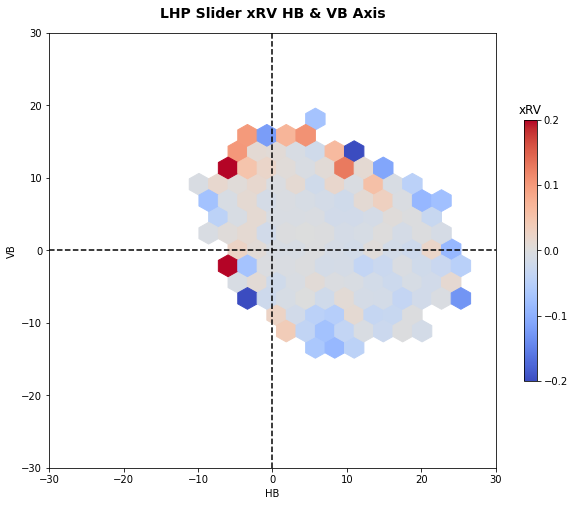

In [66]:
plt.figure(figsize = (10, 8))
plt.hexbin(sl_l['pfx_x'], sl_l['pfx_z'], C = sl_l['xRV'], cmap = 'coolwarm', mincnt = 1, gridsize = 15)
cb = plt.colorbar(ticks = [-.2,-.1, 0, .1, .2], shrink = .6)
cb.ax.set_title('xRV'), plt.clim(-.2, .2)
plt.xlabel('HB'), plt.ylabel('VB'), plt.xlim(-30, 30), plt.ylim(-30, 30)
plt.axhline(0, color = 'black', ls = '--'), plt.axvline(0, color = 'black', ls = '--')
plt.title('LHP Slider xRV HB & VB Axis', fontsize = 14, fontweight = 'bold', pad = 15);
print('LHP Slider Avg xRunValue:', round(sl_l.xRV.mean(), 2))

### LHP Slider xRV by Release Extension

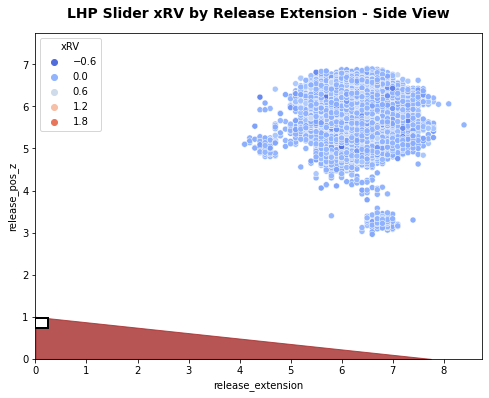

In [67]:
plt.figure(figsize = (8, 6))

sns.scatterplot(data = sl_l, x = 'release_extension', y = 'release_pos_z', hue = 'xRV', palette = 'coolwarm')
plt.xlim(0, 8.75), plt.ylim(0, 7.75)
plt.gca().add_patch(Rectangle((0, .74), .24, .24, fill = True, fc = 'white', ec = 'black', linewidth = 2))
plt.fill_between((7.75, 0), (0, 1), color = 'brown', alpha = .8)
plt.title('LHP Slider xRV by Release Extension - Side View', fontsize = 14, fontweight = 'bold', pad = 15);

### LHP Slider xRV by Release Point

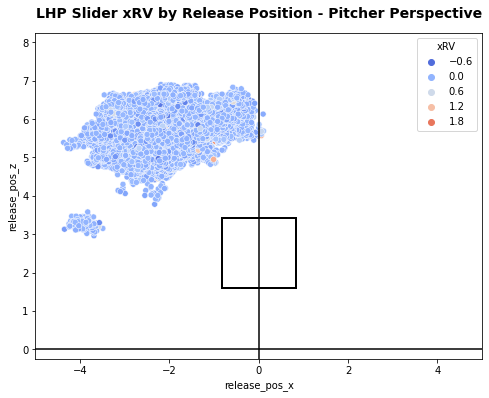

In [68]:
plt.figure(figsize = (8, 6))

sns.scatterplot(data = sl_l, x = 'release_pos_x', y = 'release_pos_z', hue = 'xRV', palette = 'coolwarm')
plt.xlim(-5, 5), plt.ylim(-0.25, 8.25)
plt.axvline(0, color = 'black'), plt.axhline(0, color = 'black')
left, bottom, width, height = (-.83, 1.59, 1.66, 1.82)
plt.gca().add_patch(Rectangle((left, bottom), width, height, fill = False, color = 'black', linewidth = 2))
plt.title('LHP Slider xRV by Release Position - Pitcher Perspective', fontsize = 14, fontweight = 'bold', pad=15);

### LHP Slider xRV by Velo & Spin Rate

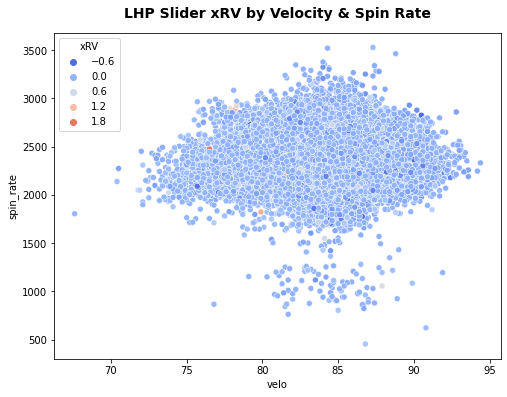

In [69]:
plt.figure(figsize = (8, 6))

sns.scatterplot(data = sl_l, x = 'velo', y = 'spin_rate', hue = 'xRV', palette = 'coolwarm')
plt.title('LHP Slider xRV by Velocity & Spin Rate', fontsize = 14, fontweight = 'bold', pad = 15);

## Curveball RHP

In [70]:
print('Baseline RHP Curveball RunValue Accuracy Score:', round(cu_r.rv.mean(), 2))

Baseline RHP Curveball RunValue Accuracy Score: -0.01


In [71]:
features_cu_r = cu_r.select_dtypes([np.number])
X = features_cu_r.drop(columns = ['rv'])
y = features_cu_r['rv']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 1)

rf = RandomForestRegressor(random_state = 1).fit(X_train, y_train)
pred_cu_r = rf.predict(X_test)
pred = rf.predict(X)

print('R2 Test Score:', round((metrics.r2_score(y_test, pred_cu_r)), 3))
print('Test RMSE:', round(np.sqrt(metrics.mean_squared_error(y_test, pred_cu_r)), 3))
print('MAE:', round(metrics.mean_absolute_error(y_test, pred_cu_r), 3), '\n')
print('R2 Score:', round((metrics.r2_score(y, pred)), 3))
print('Test RMSE:', round(np.sqrt(metrics.mean_squared_error(y, pred)), 3))
print('MAE:', round(metrics.mean_absolute_error(y, pred), 3))

R2 Test Score: -0.054
Test RMSE: 0.236
MAE: 0.114 

R2 Score: 0.626
Test RMSE: 0.141
MAE: 0.061


### RHP Curveball Actual & Predicted Run Values

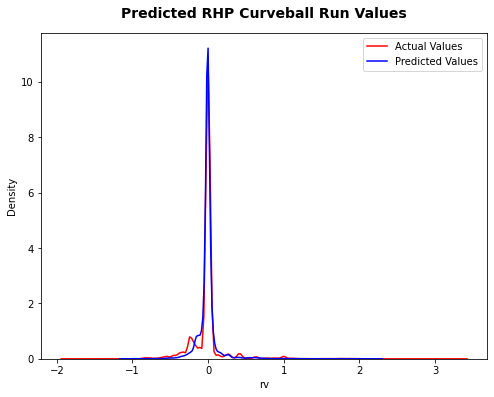

In [72]:
plt.figure(figsize = (8, 6))

ax = sns.distplot(y, hist = False, color = 'r', label = 'Actual Values')
sns.distplot(pred, hist = False, color = 'b', label = 'Predicted Values', ax = ax)
plt.legend()
plt.title('Predicted RHP Curveball Run Values', fontsize = 14, fontweight = 'bold', pad = 15);

### RHP Curveball RV Table

In [73]:
cu_r['n_pitches'] = [1 if x == 'CU' else 0 for x in cu_r['pitch_type']]
cu_r['xRV'] = pred
grouped_cu_r = cu_r.groupby(['player_name', 'pitch_type'], 
                            as_index = False)['n_pitches', 'velo', 'pfx_x', 'pfx_z', 'spin_rate', 
                                              'release_pos_x', 'release_pos_z', 'arm_angle', 'rv', 'xRV'].sum()
grouped_cu_r['RV/100'] = round(((grouped_cu_r['rv'] / grouped_cu_r['n_pitches']) * 100), 2)
grouped_cu_r['xRV/100'] = round(((grouped_cu_r['xRV'] / grouped_cu_r['n_pitches']) * 100), 2)

cu_r_group = pd.merge(cu_r, grouped_cu_r, how = 'left', on = ['player_name'])
cu_r_group.drop(columns = drop_cols, inplace = True)
cu_r_group.rename(columns = col_dict, inplace = True)
cu_r_rv_table = cu_r_group.groupby(['player_name', 'p_throws', 'pitch_type'], 
                                   as_index = False)['n_pitches', 'velo', 'HB', 'VB', 'spin_rate',
                                                     'release_pos_x', 'release_pos_z', 'arm_angle',
                                                     'RV', 'RV/100', 'xRV', 'xRV/100'].mean()
cu_r_rv_table = cu_r_rv_table.round(1)
print(cu_r_rv_table.shape)
cu_r_rv_table.head()

(335, 15)


,player_name,p_throws,pitch_type,n_pitches,velo,HB,VB,spin_rate,release_pos_x,release_pos_z,arm_angle,RV,RV/100,xRV,xRV/100
0,"Abbott, Cory",R,CU,58.0,84.1,-5.6,-9.9,2439.1,2.7,5.8,42.1,-3.7,-6.4,-2.8,-4.9
1,"Abreu, Albert",R,CU,1.0,81.0,-9.5,-13.9,2561.0,2.5,5.8,40.3,0.0,0.0,-0.0,-0.2
2,"Abreu, Bryan",R,CU,121.0,86.5,-7.5,-10.0,2787.1,1.6,6.1,28.5,2.9,2.4,-1.3,-1.1
3,"Alcantara, Sandy",R,CU,79.0,83.7,-3.8,-3.8,2395.7,2.3,6.0,37.5,2.5,3.1,1.2,1.5
4,"Alexy, A.J.",R,CU,34.0,76.2,-9.6,-17.2,2468.7,1.0,6.1,20.4,-0.1,-0.3,0.0,0.1


### RHP Curveball xRV by HB & VB

RHP Curveball Avg xRunValue: -0.01


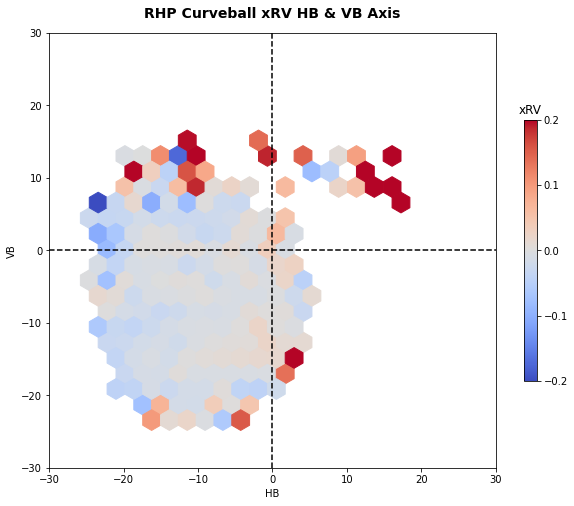

In [74]:
plt.figure(figsize = (10, 8))

plt.hexbin(cu_r['pfx_x'], cu_r['pfx_z'], C = cu_r['xRV'], cmap = 'coolwarm', mincnt = 1, gridsize = 20)
cb = plt.colorbar(ticks = [-.2,-.1, 0, .1, .2], shrink = .6)
cb.ax.set_title('xRV'), plt.clim(-.2, .2)
plt.xlabel('HB'), plt.ylabel('VB'), plt.xlim(-30, 30), plt.ylim(-30, 30)
plt.axhline(0, color = 'black', ls = '--'), plt.axvline(0, color = 'black', ls = '--')
plt.title('RHP Curveball xRV HB & VB Axis', fontsize = 14, fontweight = 'bold', pad = 15);
print('RHP Curveball Avg xRunValue:', round(cu_r.xRV.mean(), 2))

### RHP Curveball xRV by Release Extension

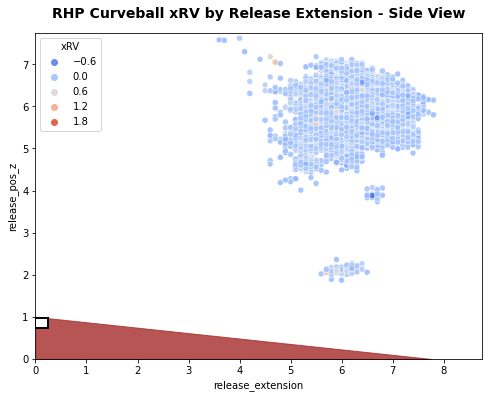

In [75]:
plt.figure(figsize = (8, 6))

sns.scatterplot(data = cu_r, x = 'release_extension', y = 'release_pos_z', hue = 'xRV', palette = 'coolwarm')
plt.xlim(0, 8.75), plt.ylim(0, 7.75)
plt.gca().add_patch(Rectangle((0, .74), .24, .24, fill = True, fc = 'white', ec = 'black', linewidth = 2))
plt.fill_between((7.75, 0), (0, 1), color = 'brown', alpha = .8)
plt.title('RHP Curveball xRV by Release Extension - Side View', fontsize = 14, fontweight = 'bold', pad = 15);

### RHP Curveball xRV by Release Point

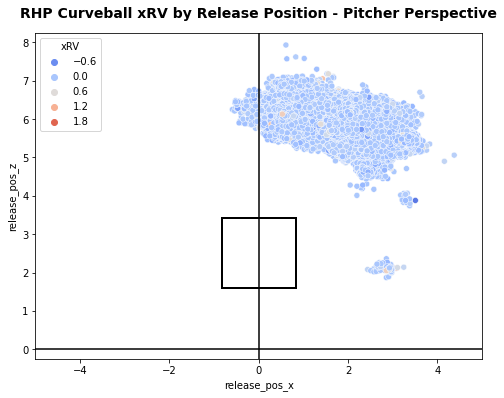

In [76]:
plt.figure(figsize = (8, 6))

sns.scatterplot(data = cu_r, x = 'release_pos_x', y = 'release_pos_z', hue = 'xRV', palette = 'coolwarm')
plt.xlim(-5, 5), plt.ylim(-0.25, 8.25)
plt.axvline(0, color = 'black'), plt.axhline(0, color = 'black')
left, bottom, width, height = (-.83, 1.59, 1.66, 1.82)
plt.gca().add_patch(Rectangle((left, bottom), width, height, fill = False, color = 'black', linewidth = 2))
plt.title('RHP Curveball xRV by Release Position - Pitcher Perspective', fontsize = 14, fontweight='bold',pad=15);

### RHP Curveball xRV by Velo & Spin Rate

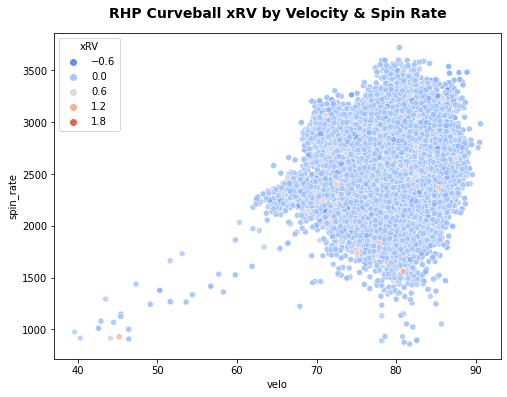

In [77]:
plt.figure(figsize = (8, 6))

sns.scatterplot(data = cu_r, x = 'velo', y = 'spin_rate', hue = 'xRV', palette = 'coolwarm')
plt.title('RHP Curveball xRV by Velocity & Spin Rate', fontsize = 14, fontweight = 'bold', pad = 15);

## Curveball LHP

In [78]:
print('Baseline LHP Curveball RunValue Accuracy Score:', round(cu_l.rv.mean(), 2))

Baseline LHP Curveball RunValue Accuracy Score: -0.01


In [79]:
features_cu_l = cu_l.select_dtypes([np.number])
X = features_cu_l.drop(columns = ['rv'])
y = features_cu_l['rv']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 1)

rf = RandomForestRegressor(random_state = 1).fit(X_train, y_train)
pred_cu_l = rf.predict(X_test)
pred = rf.predict(X)

print('R2 Test Score:', round((metrics.r2_score(y_test, pred_cu_l)), 3))
print('Test RMSE:', round(np.sqrt(metrics.mean_squared_error(y_test, pred_cu_l)), 3))
print('Test MAE:', round(metrics.mean_absolute_error(y_test, pred_cu_l), 3), '\n')
print('R2 Score:', round((metrics.r2_score(y, pred)), 3))
print('RMSE:', round(np.sqrt(metrics.mean_squared_error(y, pred)), 3))
print('MAE:', round(metrics.mean_absolute_error(y, pred), 3))

R2 Test Score: -0.079
Test RMSE: 0.234
Test MAE: 0.118 

R2 Score: 0.633
RMSE: 0.141
MAE: 0.064


### LHP Curveball Actual & Predicted Run Values

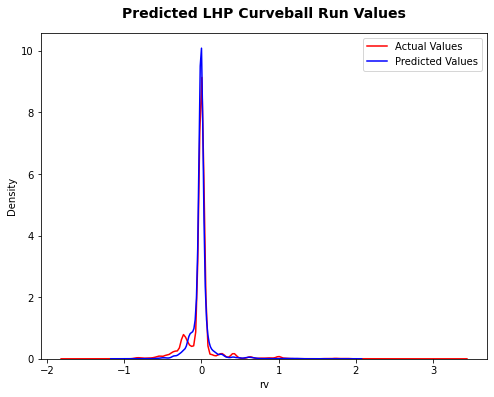

In [80]:
plt.figure(figsize = (8, 6))

ax = sns.distplot(y, hist = False, color = 'r', label = 'Actual Values')
sns.distplot(pred, hist = False, color = 'b', label = 'Predicted Values', ax = ax)
plt.legend()
plt.title('Predicted LHP Curveball Run Values', fontsize = 14, fontweight = 'bold', pad = 15);

### LHP Curveball RV Table

In [81]:
cu_l['n_pitches'] = [1 if x == 'CU' else 0 for x in cu_l['pitch_type']]
cu_l['xRV'] = pred
grouped_cu_l = cu_l.groupby(['player_name', 'pitch_type'], 
                            as_index = False)['n_pitches', 'velo', 'pfx_x', 'pfx_z', 'spin_rate', 
                                              'release_pos_x', 'release_pos_z', 'arm_angle', 'rv', 'xRV'].sum()
grouped_cu_l['RV/100'] = round(((grouped_cu_l['rv'] / grouped_cu_l['n_pitches']) * 100), 2)
grouped_cu_l['xRV/100'] = round(((grouped_cu_l['xRV'] / grouped_cu_l['n_pitches']) * 100), 2)

cu_l_group = pd.merge(cu_l, grouped_cu_l, how = 'left', on = ['player_name'])
cu_l_group.drop(columns = drop_cols, inplace = True)
cu_l_group.rename(columns = col_dict, inplace = True)
cu_l_rv_table = cu_l_group.groupby(['player_name', 'p_throws', 'pitch_type'], 
                                   as_index = False)['n_pitches', 'velo', 'HB', 'VB', 'spin_rate',
                                                     'release_pos_x', 'release_pos_z', 'arm_angle',
                                                     'RV', 'RV/100', 'xRV', 'xRV/100'].mean()
cu_l_rv_table = cu_l_rv_table.round(1)
print(cu_l_rv_table.shape)
cu_l_rv_table.head()

(133, 15)


,player_name,p_throws,pitch_type,n_pitches,velo,HB,VB,spin_rate,release_pos_x,release_pos_z,arm_angle,RV,RV/100,xRV,xRV/100
0,"Aguilar, Miguel",L,CU,19.0,80.4,14.2,5.7,2392.6,-1.2,5.3,40.1,-2.3,-12.2,-1.1,-6.0
1,"Akin, Keegan",L,CU,69.0,76.5,6.0,-4.1,2410.7,-2.5,5.7,83.8,1.1,1.6,-0.4,-0.5
2,"Albers, Andrew",L,CU,25.0,68.8,8.3,-9.7,2259.5,-1.8,6.0,55.6,0.7,2.9,0.2,0.7
3,"Allard, Kolby",L,CU,227.0,75.9,4.5,-8.9,1896.1,-2.1,5.6,69.3,0.4,0.2,-0.5,-0.2
4,"Allen, Logan",L,CU,78.0,76.8,9.5,-13.5,2705.6,-2.0,6.2,61.0,0.4,0.6,-0.0,-0.0


### LHP Curveball xRV by HB & VB

LHP Curveball Avg xRunValue: -0.01


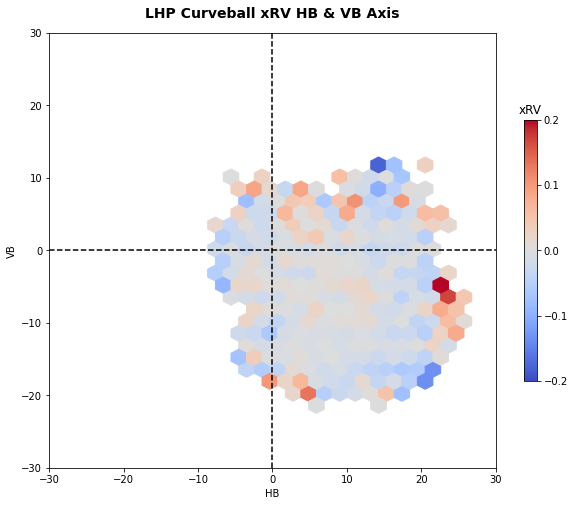

In [82]:
plt.figure(figsize = (10, 8))

plt.hexbin(cu_l['pfx_x'], cu_l['pfx_z'], C = cu_l['xRV'], cmap = 'coolwarm', mincnt = 1, gridsize = 20)
cb = plt.colorbar(ticks = [-.2,-.1, 0, .1, .2], shrink = .6)
cb.ax.set_title('xRV'), plt.clim(-.2, .2)
plt.xlabel('HB'), plt.ylabel('VB'), plt.xlim(-30, 30), plt.ylim(-30, 30)
plt.axhline(0, color = 'black', ls = '--'), plt.axvline(0, color = 'black', ls = '--')
plt.title('LHP Curveball xRV HB & VB Axis', fontsize = 14, fontweight = 'bold', pad = 15);
print('LHP Curveball Avg xRunValue:', round(cu_l.xRV.mean(), 2))

### LHP Curveball xRV by Release Extension

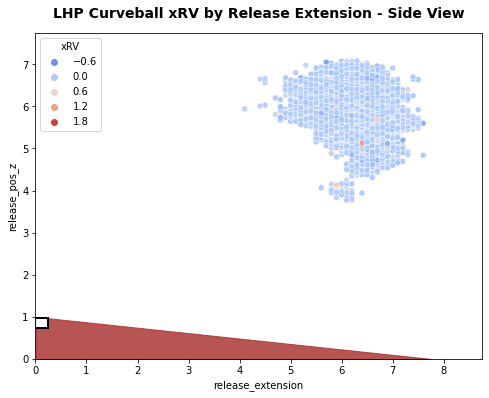

In [83]:
plt.figure(figsize = (8, 6))

sns.scatterplot(data = cu_l, x = 'release_extension', y = 'release_pos_z', hue = 'xRV', palette = 'coolwarm')
plt.xlim(0, 8.75), plt.ylim(0, 7.75)
plt.gca().add_patch(Rectangle((0, .74), .24, .24, fill = True, fc = 'white', ec = 'black', linewidth = 2))
plt.fill_between((7.75, 0), (0, 1), color = 'brown', alpha = .8)
plt.title('LHP Curveball xRV by Release Extension - Side View', fontsize = 14, fontweight = 'bold', pad = 15);

### LHP Curveball xRV by Release Point

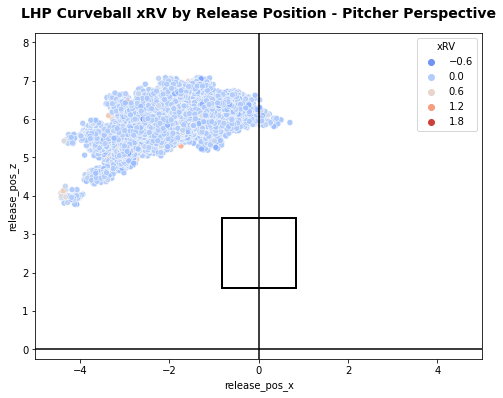

In [84]:
plt.figure(figsize = (8, 6))

sns.scatterplot(data = cu_l, x = 'release_pos_x', y = 'release_pos_z', hue = 'xRV', palette = 'coolwarm')
plt.xlim(-5, 5), plt.ylim(-0.25, 8.25)
plt.axvline(0, color = 'black'), plt.axhline(0, color = 'black')
left, bottom, width, height = (-.83, 1.59, 1.66, 1.82)
plt.gca().add_patch(Rectangle((left, bottom), width, height, fill = False, color = 'black', linewidth = 2))
plt.title('LHP Curveball xRV by Release Position - Pitcher Perspective', fontsize = 14, fontweight='bold',pad=15);

### LHP Curveball xRV by Velo & Spin Rate

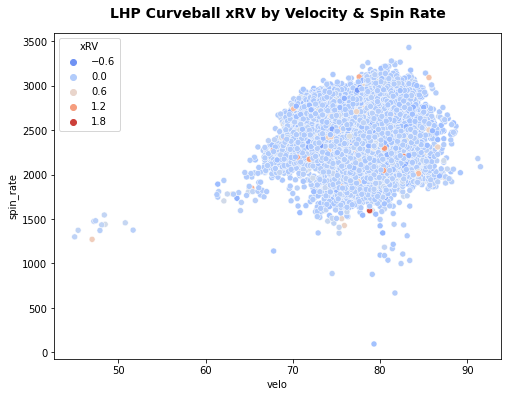

In [85]:
plt.figure(figsize = (8, 6))

sns.scatterplot(data = cu_l, x = 'velo', y = 'spin_rate', hue = 'xRV', palette = 'coolwarm')
plt.title('LHP Curveball xRV by Velocity & Spin Rate', fontsize = 14, fontweight = 'bold', pad = 15);

## Changeup RHP

In [86]:
print('Baseline RHP Changeup RunValue Accuracy Score:', round(ch_r.rv.mean(), 2))

Baseline RHP Changeup RunValue Accuracy Score: -0.0


In [87]:
features_ch_r = ch_r.select_dtypes([np.number])
X = features_ch_r.drop(columns = ['rv'])
y = features_ch_r['rv']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 1)

rf = RandomForestRegressor(random_state = 1).fit(X_train, y_train)
pred_ch_r = rf.predict(X_test)
pred = rf.predict(X)

print('R2 Test Score:', round((metrics.r2_score(y_test, pred_ch_r)), 3))
print('Test RMSE:', round(np.sqrt(metrics.mean_squared_error(y_test, pred_ch_r)), 3))
print('Test MAE:', round(metrics.mean_absolute_error(y_test, pred_ch_r), 3), '\n')
print('R2 Score:', round((metrics.r2_score(y, pred)), 3))
print('RMSE:', round(np.sqrt(metrics.mean_squared_error(y, pred)), 3))
print('MAE:', round(metrics.mean_absolute_error(y, pred), 3))

R2 Test Score: -0.034
Test RMSE: 0.267
Test MAE: 0.133 

R2 Score: 0.622
RMSE: 0.158
MAE: 0.071


### RHP Changeup Actual & Predicted Values

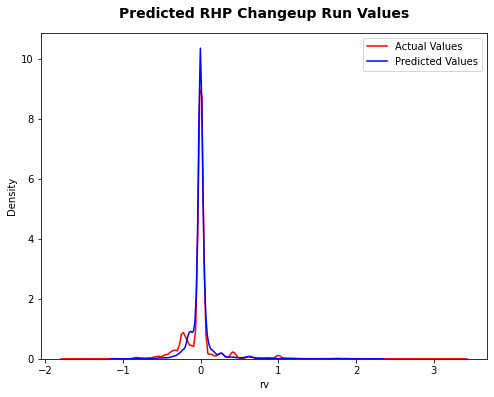

In [88]:
plt.figure(figsize = (8, 6))

ax = sns.distplot(y, hist = False, color = 'r', label = 'Actual Values')
sns.distplot(pred, hist = False, color = 'b', label = 'Predicted Values', ax = ax)
plt.legend()
plt.title('Predicted RHP Changeup Run Values', fontsize = 14, fontweight = 'bold', pad = 15);

### RHP Changeup RV Table

In [89]:
ch_r['n_pitches'] = [1 if x == 'CH' else 0 for x in ch_r['pitch_type']]
ch_r['xRV'] = pred
grouped_ch_r = ch_r.groupby(['player_name', 'pitch_type'], 
                            as_index = False)['n_pitches', 'velo', 'pfx_x', 'pfx_z', 'spin_rate', 
                                              'release_pos_x', 'release_pos_z', 'arm_angle', 'rv', 'xRV'].sum()
grouped_ch_r['RV/100'] = round(((grouped_ch_r['rv'] / grouped_ch_r['n_pitches']) * 100), 2)
grouped_ch_r['xRV/100'] = round(((grouped_ch_r['xRV'] / grouped_ch_r['n_pitches']) * 100), 2)

ch_r_group = pd.merge(ch_r, grouped_ch_r, how = 'left', on = ['player_name'])
ch_r_group.drop(columns = drop_cols, inplace = True)
ch_r_group.rename(columns = col_dict, inplace = True)
ch_r_rv_table = ch_r_group.groupby(['player_name', 'p_throws', 'pitch_type'], 
                                   as_index = False)['n_pitches', 'velo', 'HB', 'VB', 'spin_rate',
                                                     'release_pos_x', 'release_pos_z', 'arm_angle',
                                                     'RV', 'RV/100', 'xRV', 'xRV/100'].mean()
ch_r_rv_table = ch_r_rv_table.round(1)
print(ch_r_rv_table.shape)
ch_r_rv_table.head()

(472, 15)


,player_name,p_throws,pitch_type,n_pitches,velo,HB,VB,spin_rate,release_pos_x,release_pos_z,arm_angle,RV,RV/100,xRV,xRV/100
0,"Abbott, Cory",R,CH,23.0,87.0,13.9,12.3,2138.7,2.4,5.7,40.3,-1.0,-4.2,-0.5,-2.1
1,"Abreu, Albert",R,CH,102.0,88.2,16.8,8.6,1780.9,2.3,5.7,38.6,2.5,2.4,2.2,2.2
2,"Acevedo, Domingo",R,CH,37.0,86.0,16.9,8.7,1790.6,1.5,6.0,27.8,-1.5,-4.1,-0.2,-0.6
3,"Adam, Jason",R,CH,22.0,87.2,15.8,2.7,1655.5,1.9,6.0,33.1,0.4,1.6,-0.2,-0.8
4,"Adon, Joan",R,CH,6.0,87.1,16.8,9.3,1884.0,2.9,6.0,43.6,0.0,0.0,-0.1,-1.5


### RHP Changeup xRV by HB & VB

RHP Changeup Avg xRunValue: -0.0


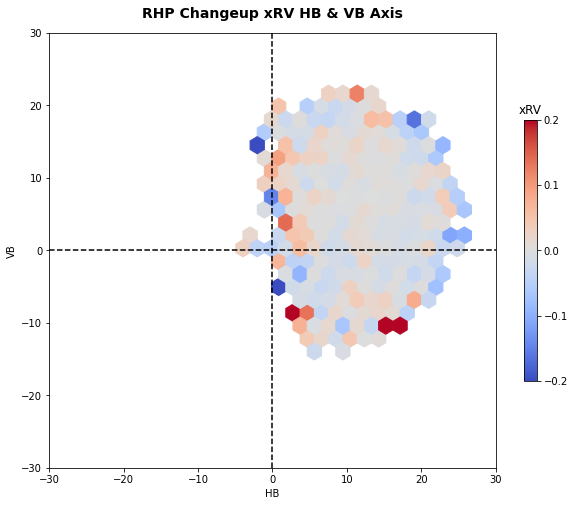

In [90]:
plt.figure(figsize = (10, 8))

plt.hexbin(ch_r['pfx_x'], ch_r['pfx_z'], C = ch_r['xRV'], cmap = 'coolwarm', mincnt = 1, gridsize = 20)
cb = plt.colorbar(ticks = [-.2,-.1, 0, .1, .2], shrink = .6)
cb.ax.set_title('xRV'), plt.clim(-.2, .2)
plt.xlabel('HB'), plt.ylabel('VB'), plt.xlim(-30, 30), plt.ylim(-30, 30)
plt.axhline(0, color = 'black', ls = '--'), plt.axvline(0, color = 'black', ls = '--')
plt.title('RHP Changeup xRV HB & VB Axis', fontsize = 14, fontweight = 'bold', pad = 15);
print('RHP Changeup Avg xRunValue:', round(ch_r.xRV.mean(), 2))

### RHP Changeup xRV by Release Point

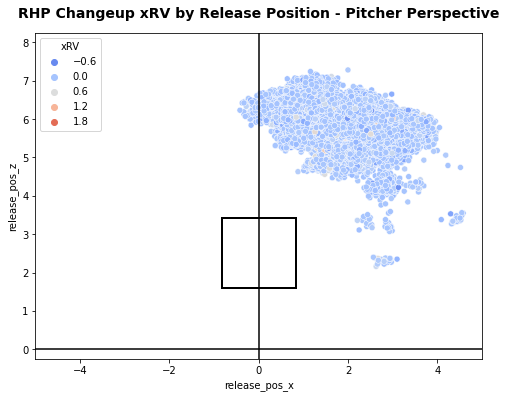

In [91]:
plt.figure(figsize = (8, 6))

sns.scatterplot(data = ch_r, x = 'release_pos_x', y = 'release_pos_z', hue = 'xRV', palette = 'coolwarm')
plt.xlim(-5, 5), plt.ylim(-0.25, 8.25)
plt.axvline(0, color = 'black'), plt.axhline(0, color = 'black')
left, bottom, width, height = (-.83, 1.59, 1.66, 1.82)
plt.gca().add_patch(Rectangle((left, bottom), width, height, fill = False, color = 'black', linewidth = 2))
plt.title('RHP Changeup xRV by Release Position - Pitcher Perspective', fontsize = 14, fontweight ='bold',pad=15);

### RHP Changeup xRV by Release Extension

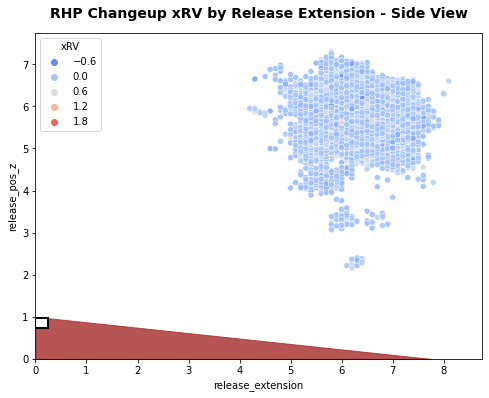

In [92]:
plt.figure(figsize = (8, 6))

sns.scatterplot(data = ch_r, x = 'release_extension', y = 'release_pos_z', hue = 'xRV', palette = 'coolwarm')
plt.xlim(0, 8.75), plt.ylim(0, 7.75)
plt.gca().add_patch(Rectangle((0, .74), .24, .24, fill = True, fc = 'white', ec = 'black', linewidth = 2))
plt.fill_between((7.75, 0), (0, 1), color = 'brown', alpha = .8)
plt.title('RHP Changeup xRV by Release Extension - Side View', fontsize = 14, fontweight = 'bold', pad = 15);

### RHP Changeup xRV by Velo & Spin Rate

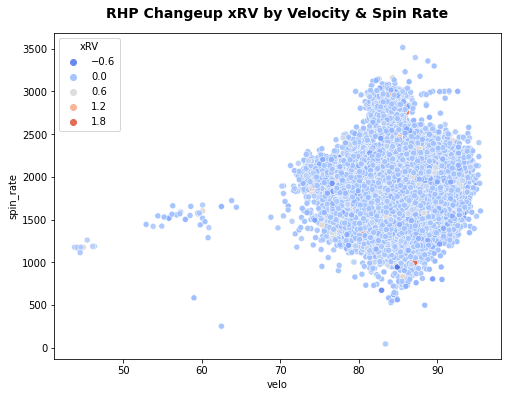

In [93]:
plt.figure(figsize = (8, 6))

sns.scatterplot(data = ch_r, x = 'velo', y = 'spin_rate', hue = 'xRV', palette = 'coolwarm')
plt.title('RHP Changeup xRV by Velocity & Spin Rate', fontsize = 14, fontweight = 'bold', pad = 15);

## Changeup LHP

In [94]:
print('Baseline LHP Changeup RunValue Accuracy Score:', round(ch_l.rv.mean(), 2))

Baseline LHP Changeup RunValue Accuracy Score: -0.0


In [95]:
features_ch_l = ch_l.select_dtypes([np.number])
X = features_ch_l.drop(columns = ['rv'])
y = features_ch_l['rv']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 1)

rf = RandomForestRegressor(random_state = 1).fit(X_train, y_train)
pred_ch_l = rf.predict(X_test)
pred = rf.predict(X)

print('R2 Test Score:', round((metrics.r2_score(y_test, pred_ch_l)), 3))
print('Test RMSE:', round(np.sqrt(metrics.mean_squared_error(y_test, pred_ch_l)), 3))
print('Test MAE:', round(metrics.mean_absolute_error(y_test, pred_ch_l), 3), '\n')
print('R2 Score:', round((metrics.r2_score(y, pred)), 3))
print('RMSE:', round(np.sqrt(metrics.mean_squared_error(y, pred)), 3))
print('MAE:', round(metrics.mean_absolute_error(y, pred), 3))

R2 Test Score: -0.052
Test RMSE: 0.268
Test MAE: 0.14 

R2 Score: 0.626
RMSE: 0.16
MAE: 0.074


### LHP Changeup Actual & Predicted Values

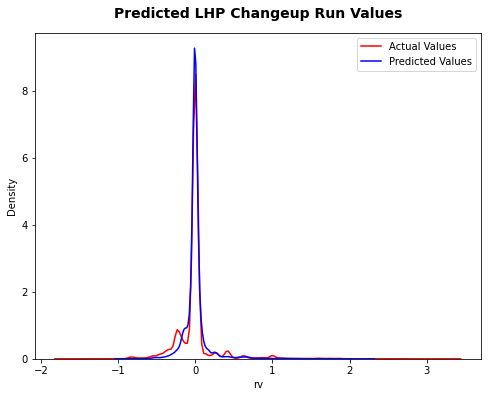

In [96]:
plt.figure(figsize = (8, 6))

ax = sns.distplot(y, hist = False, color = 'r', label = 'Actual Values')
sns.distplot(pred, hist = False, color = 'b', label = 'Predicted Values', ax = ax)
plt.legend()
plt.title('Predicted LHP Changeup Run Values', fontsize = 14, fontweight = 'bold', pad = 15);

### LHP Changeup RV Table

In [97]:
ch_l['n_pitches'] = [1 if x == 'CH' else 0 for x in ch_l['pitch_type']]
ch_l['xRV'] = pred
grouped_ch_l = ch_l.groupby(['player_name', 'pitch_type'], 
                            as_index = False)['n_pitches', 'velo', 'pfx_x', 'pfx_z', 'spin_rate', 
                                              'release_pos_x', 'release_pos_z', 'arm_angle', 'rv', 'xRV'].sum()
grouped_ch_l['RV/100'] = round(((grouped_ch_l['rv'] / grouped_ch_l['n_pitches']) * 100), 2)
grouped_ch_l['xRV/100'] = round(((grouped_ch_l['xRV'] / grouped_ch_l['n_pitches']) * 100), 2)

ch_l_group = pd.merge(ch_l, grouped_ch_l, how = 'left', on = ['player_name'])
ch_l_group.drop(columns = drop_cols, inplace = True)
ch_l_group.rename(columns = col_dict, inplace = True)
ch_l_rv_table = ch_l_group.groupby(['player_name', 'p_throws', 'pitch_type'], 
                                   as_index = False)['n_pitches', 'velo', 'HB', 'VB', 'spin_rate',
                                                     'release_pos_x', 'release_pos_z', 'arm_angle',
                                                     'RV', 'RV/100', 'xRV', 'xRV/100'].mean()
ch_l_rv_table = ch_l_rv_table.round(1)
print(ch_l_rv_table.shape)
ch_l_rv_table.head()

(180, 15)


,player_name,p_throws,pitch_type,n_pitches,velo,HB,VB,spin_rate,release_pos_x,release_pos_z,arm_angle,RV,RV/100,xRV,xRV/100
0,"Abad, Fernando",L,CH,46.0,75.1,-10.7,14.2,1637.7,-0.7,6.4,17.7,-2.4,-5.2,-1.9,-4.0
1,"Aguilar, Miguel",L,CH,3.0,85.8,-14.9,8.9,1781.3,-1.0,5.3,31.5,0.0,0.0,-0.1,-2.2
2,"Akin, Keegan",L,CH,344.0,81.9,-15.3,8.4,1937.5,-2.5,5.7,83.2,7.2,2.1,3.7,1.1
3,"Albers, Andrew",L,CH,53.0,80.0,-12.7,7.7,1407.5,-2.2,5.9,70.2,-1.2,-2.3,-0.7,-1.2
4,"Alexander, Scott",L,CH,22.0,86.2,-13.6,4.5,1608.6,-1.8,5.7,57.0,0.3,1.3,0.5,2.3


### LHP Changeup xRV by HB & VB

LHP Changeup Avg xRunValue: 0.0


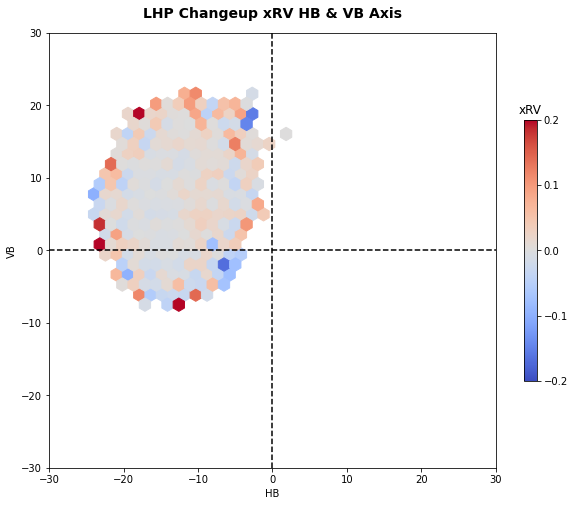

In [98]:
plt.figure(figsize = (10, 8))

plt.hexbin(ch_l['pfx_x'], ch_l['pfx_z'], C = ch_l['xRV'], cmap = 'coolwarm', mincnt = 1, gridsize = 20)
cb = plt.colorbar(ticks = [-.2,-.1, 0, .1, .2], shrink = .6)
cb.ax.set_title('xRV'), plt.clim(-.2, .2)
plt.xlabel('HB'), plt.ylabel('VB'), plt.xlim(-30, 30), plt.ylim(-30, 30)
plt.axhline(0, color = 'black', ls = '--'), plt.axvline(0, color = 'black', ls = '--')
plt.title('LHP Changeup xRV HB & VB Axis', fontsize = 14, fontweight = 'bold', pad = 15);
print('LHP Changeup Avg xRunValue:', round(ch_l.xRV.mean(), 2))

### LHP Changeup xRV by Release Point

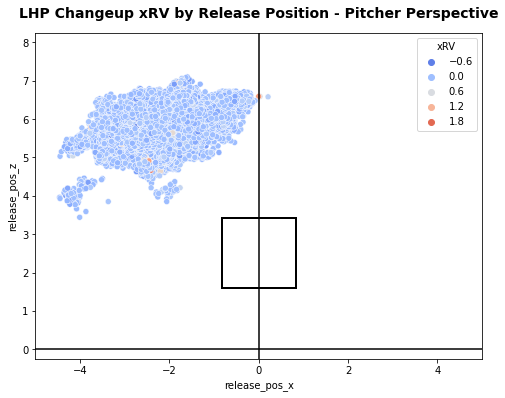

In [99]:
plt.figure(figsize = (8, 6))

sns.scatterplot(data = ch_l, x = 'release_pos_x', y = 'release_pos_z', hue = 'xRV', palette = 'coolwarm')
plt.xlim(-5, 5), plt.ylim(-0.25, 8.25)
plt.axvline(0, color = 'black'), plt.axhline(0, color = 'black')
left, bottom, width, height = (-.83, 1.59, 1.66, 1.82)
plt.gca().add_patch(Rectangle((left, bottom), width, height, fill = False, color = 'black', linewidth = 2))
plt.title('LHP Changeup xRV by Release Position - Pitcher Perspective', fontsize = 14, fontweight ='bold',pad=15);

### LHP Changeup xRV by Release Extension

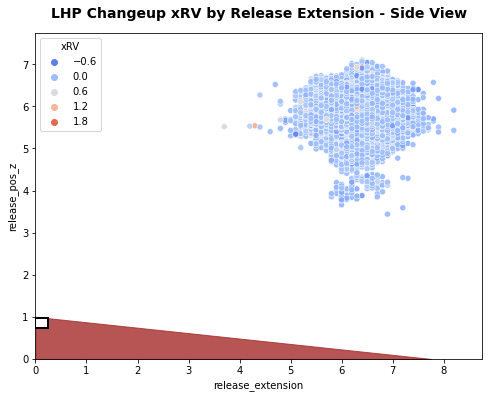

In [100]:
plt.figure(figsize = (8, 6))

sns.scatterplot(data = ch_l, x = 'release_extension', y = 'release_pos_z', hue = 'xRV', palette = 'coolwarm')
plt.xlim(0, 8.75), plt.ylim(0, 7.75)
plt.gca().add_patch(Rectangle((0, .74), .24, .24, fill = True, fc = 'white', ec = 'black', linewidth = 2))
plt.fill_between((7.75, 0), (0, 1), color = 'brown', alpha = .8)
plt.title('LHP Changeup xRV by Release Extension - Side View', fontsize = 14, fontweight = 'bold', pad = 15);

### LHP Changeup xRV by Velo & Spin Rate

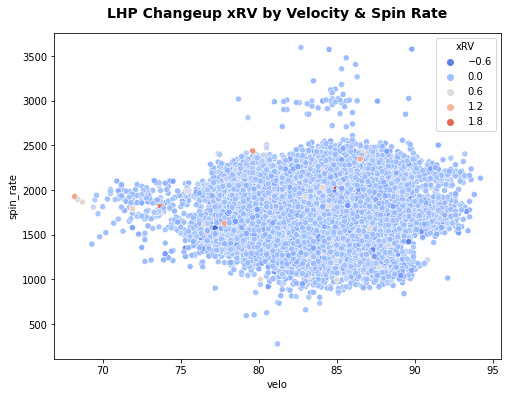

In [101]:
plt.figure(figsize = (8, 6))

sns.scatterplot(data = ch_l, x = 'velo', y = 'spin_rate', hue = 'xRV', palette = 'coolwarm')
plt.title('LHP Changeup xRV by Velocity & Spin Rate', fontsize = 14, fontweight = 'bold', pad = 15);

### Save RV tables to CSV

In [102]:
xrv_predictions = pd.concat([ff_r, ff_l, fc_r, fc_l, si_r, si_l, sl_r, sl_l, cu_r, cu_l, ch_r, ch_l], 
                        ignore_index = True)
xrv_predictions.to_csv('../data/xrv-pitches.csv')

rv_pitches_table = pd.concat([ff_r_rv_table, ff_l_rv_table, fc_r_rv_table, fc_l_rv_table, si_r_rv_table, 
                              si_l_rv_table, sl_r_rv_table, sl_l_rv_table, cu_r_rv_table, cu_l_rv_table, 
                              ch_r_rv_table, ch_l_rv_table], 
                             ignore_index = True)
rv_pitches_table.to_csv('../data/pitches-rv-table.csv')